In [1]:
!pip install flair

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import os, re, csv, string, random
import flair
# print(flair.__version__)


import nltk
from nltk.tokenize import RegexpTokenizer

from flair.data import Sentence, Span, Corpus, Dictionary, Token
from flair.embeddings import WordEmbeddings, DocumentPoolEmbeddings, FlairEmbeddings, StackedEmbeddings, TokenEmbeddings
from flair.models import SequenceTagger

from flair.datasets import ColumnCorpus
from flair.trainers import ModelTrainer

from typing import List, Tuple

from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns
import pickle

from tqdm.auto import tqdm, trange

# import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
# from flair.data import Sentence

In [3]:
from google.colab import drive
drive.mount("/content/drive")

os.chdir('/content/drive/MyDrive/SI 630 project')
# os.listdir('.')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
os.listdir('datasets/CADEC/CADEC.v2/cadec')


['sct',
 'text',
 'original - unedited version of edited files',
 'meddra - unedited version of edited files',
 'sct - unedited version of edited files',
 'original',
 'meddra']

In [5]:
suf = '_v2'

data_save_dir = 'data'+suf

In [6]:
meddra_counts = pd.read_csv(data_save_dir+'/meddra_counts.csv')
meddra_counts

,ner,meddra,counts_exploded,counts,counts_exploded_rank
0,Drug,Lipitor,1081,1073,1
1,ADR,CONCEPT_LESS,1016,266,2
2,ADR,Severe_pain,722,247,3
3,ADR,Myalgia,619,305,4
4,ADR,Pain,292,260,5
...,...,...,...,...,...
1294,Finding,Senility,1,1,1233
1295,Drug,Seroquel,1,1,1233
1296,Drug,Solaraze,1,1,1233
1297,Drug,Tagamet,1,1,1233


In [7]:
meddra_counts.loc[meddra_counts.ner == 'ADR',:]

,ner,meddra,counts_exploded,counts,counts_exploded_rank
1,ADR,CONCEPT_LESS,1016,266,2
2,ADR,Severe_pain,722,247,3
3,ADR,Myalgia,619,305,4
4,ADR,Pain,292,260,5
5,ADR,Arthralgia,280,163,6
...,...,...,...,...,...
1268,ADR,Labyrinthitis,1,1,1233
1269,ADR,Dysphagia,1,1,1233
1275,ADR,Lupus_erythematosus,1,1,1233
1278,ADR,Cataract,1,1,1233


In [8]:
with open(data_save_dir+'/cadec_flair_objects.pkl', 'rb') as f:
    docs = pickle.load(f)
docs[:10]

[Sentence[117]: "i feel a bit drowsy & have a little blurred vision , so far no gastric problems . ive been on arthrotec 50 for over 10 years on and off , only taking it when i needed it . due to my arthritis getting progressively worse , to the point where i am in tears with the agony , gp ' s started me on 75 twice a day and i have to take it . every day for the next month to see how i get on , here goes . so far its been very good , pains almost gone , but i feel a bit weird , didnt have that when on 50 ." → ["i"/O/O, "feel"/O/O, "a"/O/O, "bit"/B-ADR/B-Drowsy, "drowsy"/E-ADR/E-Drowsy, "&"/O/O, "have"/O/O, "a"/O/O, "little"/B-ADR/B-Blurred_vision_-_hazy, "blurred"/I-ADR/I-Blurred_vision_-_hazy, "vision"/E-ADR/E-Blurred_vision_-_hazy, ","/O/O, "so"/O/O, "far"/O/O, "no"/O/O, "gastric"/B-ADR/B-Excessive_upper_gastrointestinal_gas, "problems"/E-ADR/E-Excessive_upper_gastrointestinal_gas, "."/O/O, "ive"/O/O, "been"/O/O, "on"/O/O, "arthrotec"/S-Drug/S-Arthrotec, "50"/O/O, "for"/O/O, "over"

In [9]:
len(docs)

1186

In [10]:
temp = docs[0]
temp

Sentence[117]: "i feel a bit drowsy & have a little blurred vision , so far no gastric problems . ive been on arthrotec 50 for over 10 years on and off , only taking it when i needed it . due to my arthritis getting progressively worse , to the point where i am in tears with the agony , gp ' s started me on 75 twice a day and i have to take it . every day for the next month to see how i get on , here goes . so far its been very good , pains almost gone , but i feel a bit weird , didnt have that when on 50 ." → ["i"/O/O, "feel"/O/O, "a"/O/O, "bit"/B-ADR/B-Drowsy, "drowsy"/E-ADR/E-Drowsy, "&"/O/O, "have"/O/O, "a"/O/O, "little"/B-ADR/B-Blurred_vision_-_hazy, "blurred"/I-ADR/I-Blurred_vision_-_hazy, "vision"/E-ADR/E-Blurred_vision_-_hazy, ","/O/O, "so"/O/O, "far"/O/O, "no"/O/O, "gastric"/B-ADR/B-Excessive_upper_gastrointestinal_gas, "problems"/E-ADR/E-Excessive_upper_gastrointestinal_gas, "."/O/O, "ive"/O/O, "been"/O/O, "on"/O/O, "arthrotec"/S-Drug/S-Arthrotec, "50"/O/O, "for"/O/O, "over"/

In [11]:
temp.annotation_layers

{'ner': ['Token[0]: "i"'/'O' (1.0),
  'Token[1]: "feel"'/'O' (1.0),
  'Token[2]: "a"'/'O' (1.0),
  'Token[3]: "bit"'/'B-ADR' (1.0),
  'Token[4]: "drowsy"'/'E-ADR' (1.0),
  'Token[5]: "&"'/'O' (1.0),
  'Token[6]: "have"'/'O' (1.0),
  'Token[7]: "a"'/'O' (1.0),
  'Token[8]: "little"'/'B-ADR' (1.0),
  'Token[9]: "blurred"'/'I-ADR' (1.0),
  'Token[10]: "vision"'/'E-ADR' (1.0),
  'Token[11]: ","'/'O' (1.0),
  'Token[12]: "so"'/'O' (1.0),
  'Token[13]: "far"'/'O' (1.0),
  'Token[14]: "no"'/'O' (1.0),
  'Token[15]: "gastric"'/'B-ADR' (1.0),
  'Token[16]: "problems"'/'E-ADR' (1.0),
  'Token[17]: "."'/'O' (1.0),
  'Token[18]: "ive"'/'O' (1.0),
  'Token[19]: "been"'/'O' (1.0),
  'Token[20]: "on"'/'O' (1.0),
  'Token[21]: "arthrotec"'/'S-Drug' (1.0),
  'Token[22]: "50"'/'O' (1.0),
  'Token[23]: "for"'/'O' (1.0),
  'Token[24]: "over"'/'O' (1.0),
  'Token[25]: "10"'/'O' (1.0),
  'Token[26]: "years"'/'O' (1.0),
  'Token[27]: "on"'/'O' (1.0),
  'Token[28]: "and"'/'O' (1.0),
  'Token[29]: "off"'/'O' (

In [12]:

# define your NER tags
label_dict = {
    'ADR': 'ADR',
    'Drug': 'Drug',
    'Finding': 'Finding',
    'Symptom': 'Symptom',
    'Disease': 'Disease'
}

In [13]:
from flair.data import Corpus
# from flair.datasets import SentenceDataset
from flair.embeddings import WordEmbeddings, FlairEmbeddings, StackedEmbeddings, TransformerWordEmbeddings
from flair.models import SequenceTagger
from flair.trainers import ModelTrainer
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset
from torch.optim import AdamW, SGD

from flair.visual.training_curves import Plotter
plotter = Plotter()



train_docs, test_docs = train_test_split(docs, test_size=0.2, random_state=321)
dev_docs, test_docs = train_test_split(test_docs, test_size=0.5, random_state=123)

corpus = Corpus(train=train_docs, dev=dev_docs, test=test_docs) # Corpus: 948 train + 119 dev + 119 test sentences
corpus.filter_empty_sentences()
# # create a tag dictionary
labels = ['ADR', 'Drug', 'Finding', 'Symptom', 'Disease']
# tag_dictionary = Dictionary(add_unk=True)
# for label in labels:
#     tag_dictionary.add_item(label)
tag_dictionary = corpus.make_label_dictionary(label_type='ner')
print(tag_dictionary.span_labels)

# create a stacked embedding using GloVe and Flair embeddings
stacked_embeddings = StackedEmbeddings([
    WordEmbeddings('glove',
                   force_cpu=False,
                #    embedding_length=1024,
                  #  fine_tune=True,
                   ),
    # TransformerWordEmbeddings('emilyalsentzer/Bio_ClinicalBERT', layers="-1",
    #                                    subtoken_pooling="first",
    #                                    is_document_embedding=True,
    #                                    fine_tune=True,
    #                                    use_context=True,
    #                                    max_seq_length=1024,
    #                                    ),
    FlairEmbeddings('news-forward',
                    # fine_tune=True
                    ),
    FlairEmbeddings('news-backward',
                    # fine_tune=True
                    ),
])
# https://github.com/flairNLP/flair/blob/master/resources/docs/embeddings/FLAIR_EMBEDDINGS.md

# create a SequenceTagger object and specify the tag dictionary and embeddings to use
tagger = SequenceTagger(hidden_size=256,
                        embeddings=stacked_embeddings,
                        tag_dictionary=tag_dictionary,
                        tag_type='ner',
                        # use_crf=False,
                        # use_rnn=False,
                        # reproject_embeddings=False,
                        )
tagger.predict_spans = False

print(tagger._determine_if_span_prediction_problem(tagger.label_dictionary))
print(tagger.predict_spans)

# https://github.com/flairNLP/flair/blob/master/flair/trainers/trainer.py
# create a ModelTrainer object and train the tagger
trainer = ModelTrainer(tagger, corpus)

2023-04-21 01:37:07,977 Filtering empty sentences
2023-04-21 01:37:07,998 Corpus: 948 train + 119 dev + 119 test sentences
2023-04-21 01:37:08,000 Computing label dictionary. Progress:


948it [00:00, 6077.09it/s]

2023-04-21 01:37:08,161 Dictionary created for label 'ner' with 22 values: O (seen 79057 times), I-ADR (seen 4449 times), E-ADR (seen 3506 times), B-ADR (seen 3349 times), S-ADR (seen 1363 times), S-Drug (seen 1286 times), B-Finding (seen 200 times), E-Finding (seen 200 times), I-Finding (seen 149 times), B-Disease (seen 119 times), E-Disease (seen 119 times), E-Symptom (seen 114 times), S-Disease (seen 112 times), S-Symptom (seen 112 times), E-Drug (seen 111 times), B-Symptom (seen 110 times), B-Drug (seen 110 times), S-Finding (seen 109 times), I-Symptom (seen 104 times), I-Drug (seen 50 times)
False


2023-04-21 01:37:16,713 SequenceTagger predicts: Dictionary with 22 tags: <unk>, O, I-ADR, E-ADR, B-ADR, S-ADR, S-Drug, B-Finding, E-Finding, I-Finding, B-Disease, E-Disease, E-Symptom, S-Disease, S-Symptom, E-Drug, B-Symptom, B-Drug, S-Finding, I-Symptom, I-Drug, I-Disease
True
False


In [14]:
# !tensorboard --logdir=runs
# http://localhost:6006/

In [15]:
hist = trainer.train('flair_ner_model'+suf,
              embeddings_storage_mode='gpu',
              gold_label_dictionary_for_eval=tag_dictionary,
              mini_batch_size = 12,
              eval_batch_size = 12,
              patience=1,
              anneal_factor = 0.5,
              anneal_against_dev_loss=True,
              main_evaluation_metric = ("weighted avg", "f1-score"),
              metrics_for_tensorboard=[("weighted avg", 'precision'), ("weighted avg", 'recall'), ("macro avg", 'f1-score'), ("macro avg", 'precision'), ("macro avg", 'recall')],
              use_tensorboard=True,
              tensorboard_comment='Flair NER',
              tensorboard_log_dir='runs/tb_logs'+suf,
              min_learning_rate=3e-8,
              optimizer=AdamW,
              learning_rate=1e-1,
              weight_decay=0.001,
              max_epochs=100,
              monitor_train=True,
              save_optimizer_state=True,)
# hist

2023-04-21 01:37:16,972 tensorboard logging path is runs/tb_logs_v2
2023-04-21 01:37:16,983 ----------------------------------------------------------------------------------------------------
2023-04-21 01:37:16,984 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
      )
    )
  )
  (word_dropout): WordDropout(p=0.05)
  (locked_dropout): LockedDropout(p=0.5)
  (embedding2nn): Linear(in_features=4196, out_features=4196, bias=True)
  (rnn): LSTM(4196, 256, batch_first=True, bidirectional=True)
  (li

100%|██████████| 79/79 [00:21<00:00,  3.71it/s]

2023-04-21 01:38:12,193 Evaluating as a multi-label problem: True


2023-04-21 01:38:14,931 TRAIN : loss 1.893505573272705 - f1-score (weighted avg)  0.1212


100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


2023-04-21 01:38:21,460 Evaluating as a multi-label problem: False
2023-04-21 01:38:21,526 DEV : loss 1.9621220827102661 - f1-score (weighted avg)  0.1224
2023-04-21 01:38:21,535 BAD EPOCHS (no improvement): 0
2023-04-21 01:38:21,539 saving best model
2023-04-21 01:38:23,549 ----------------------------------------------------------------------------------------------------
2023-04-21 01:38:25,553 epoch 2 - iter 7/79 - loss 2.67268115 - time (sec): 2.00 - samples/sec: 4214.37 - lr: 0.100000
2023-04-21 01:38:27,020 epoch 2 - iter 14/79 - loss 3.12651882 - time (sec): 3.47 - samples/sec: 4731.92 - lr: 0.100000
2023-04-21 01:38:28,721 epoch 2 - iter 21/79 - loss 3.32248311 - time (sec): 5.17 - samples/sec: 4792.40 - lr: 0.100000
2023-04-21 01:38:30,257 epoch 2 - iter 28/79 - loss 3.57550108 - time (sec): 6.71 - samples/sec: 4797.07 - lr: 0.100000
2023-04-21 01:38:31,945 epoch 2 - iter 35/79 - loss 3.60043622 - time (sec): 8.39 - samples/sec: 4806.55 - lr: 0.100000
2023-04-21 01:38:34,374 

100%|██████████| 79/79 [00:21<00:00,  3.67it/s]

2023-04-21 01:39:05,315 Evaluating as a multi-label problem: True


2023-04-21 01:39:08,079 TRAIN : loss 2.6930272579193115 - f1-score (weighted avg)  0.0699


100%|██████████| 10/10 [00:02<00:00,  3.55it/s]

2023-04-21 01:39:10,974 Evaluating as a multi-label problem: False
2023-04-21 01:39:11,041 DEV : loss 2.6982486248016357 - f1-score (weighted avg)  0.0729
2023-04-21 01:39:11,050 BAD EPOCHS (no improvement): 1
2023-04-21 01:39:11,054 ----------------------------------------------------------------------------------------------------


2023-04-21 01:39:12,923 epoch 3 - iter 7/79 - loss 3.42127798 - time (sec): 1.87 - samples/sec: 4492.46 - lr: 0.100000
2023-04-21 01:39:14,490 epoch 3 - iter 14/79 - loss 3.30537078 - time (sec): 3.43 - samples/sec: 4782.15 - lr: 0.100000
2023-04-21 01:39:16,650 epoch 3 - iter 21/79 - loss 3.32627054 - time (sec): 5.59 - samples/sec: 4597.17 - lr: 0.100000
2023-04-21 01:39:19,011 epoch 3 - iter 28/79 - loss 3.24062048 - time (sec): 7.95 - samples/sec: 4516.48 - lr: 0.100000
2023-04-21 01:39:20,664 epoch 3 - iter 35/79 - loss 3.35287275 - time (sec): 9.61 - samples/sec: 4581.96 - lr: 0.100000
2023-04-21 01:39:22,335 epoch 3 - iter 42/79 - loss 3.27128971 - time (sec): 11.28 - samples/sec: 4592.75 - lr: 0.100000
2023-04-21 01:39:23,831 epoch 3 - iter 49/79 - loss 3.35850528 - time (sec): 12.77 - samples/sec: 4652.19 - lr: 0.100000
2023-04-21 01:39:25,462 epoch 3 - iter 56/79 - loss 3.29298585 - time (sec): 14.41 - samples/sec: 4725.46 - lr: 0.100000
2023-04-21 01:39:27,081 epoch 3 - iter

100%|██████████| 79/79 [00:21<00:00,  3.69it/s]

2023-04-21 01:39:52,512 Evaluating as a multi-label problem: True


2023-04-21 01:39:56,451 TRAIN : loss 2.871452808380127 - f1-score (weighted avg)  0.0673


100%|██████████| 10/10 [00:02<00:00,  3.64it/s]

2023-04-21 01:39:59,280 Evaluating as a multi-label problem: False
2023-04-21 01:39:59,345 DEV : loss 3.0032033920288086 - f1-score (weighted avg)  0.0632
2023-04-21 01:39:59,354 Epoch     3: reducing learning rate of group 0 to 5.0000e-02.
2023-04-21 01:39:59,356 BAD EPOCHS (no improvement): 2
2023-04-21 01:39:59,359 ----------------------------------------------------------------------------------------------------


2023-04-21 01:40:01,127 epoch 4 - iter 7/79 - loss 3.98643937 - time (sec): 1.77 - samples/sec: 4683.52 - lr: 0.050000
2023-04-21 01:40:02,613 epoch 4 - iter 14/79 - loss 3.40115906 - time (sec): 3.25 - samples/sec: 5088.96 - lr: 0.050000
2023-04-21 01:40:04,212 epoch 4 - iter 21/79 - loss 3.22085479 - time (sec): 4.85 - samples/sec: 4908.81 - lr: 0.050000
2023-04-21 01:40:06,829 epoch 4 - iter 28/79 - loss 2.89564295 - time (sec): 7.47 - samples/sec: 4496.81 - lr: 0.050000
2023-04-21 01:40:08,342 epoch 4 - iter 35/79 - loss 2.82942186 - time (sec): 8.98 - samples/sec: 4719.92 - lr: 0.050000
2023-04-21 01:40:09,865 epoch 4 - iter 42/79 - loss 2.82470698 - time (sec): 10.50 - samples/sec: 4740.00 - lr: 0.050000
2023-04-21 01:40:11,573 epoch 4 - iter 49/79 - loss 2.78574573 - time (sec): 12.21 - samples/sec: 4805.04 - lr: 0.050000
2023-04-21 01:40:13,307 epoch 4 - iter 56/79 - loss 2.72692259 - time (sec): 13.95 - samples/sec: 4828.88 - lr: 0.050000
2023-04-21 01:40:14,849 epoch 4 - iter

100%|██████████| 79/79 [00:21<00:00,  3.69it/s]

2023-04-21 01:40:40,420 Evaluating as a multi-label problem: True


2023-04-21 01:40:43,174 TRAIN : loss 1.9468613862991333 - f1-score (weighted avg)  0.067


100%|██████████| 10/10 [00:02<00:00,  3.64it/s]

2023-04-21 01:40:46,003 Evaluating as a multi-label problem: False
2023-04-21 01:40:46,068 DEV : loss 2.089040517807007 - f1-score (weighted avg)  0.0689
2023-04-21 01:40:46,077 BAD EPOCHS (no improvement): 1
2023-04-21 01:40:46,080 ----------------------------------------------------------------------------------------------------


2023-04-21 01:40:47,674 epoch 5 - iter 7/79 - loss 2.36757401 - time (sec): 1.59 - samples/sec: 5244.58 - lr: 0.050000
2023-04-21 01:40:49,343 epoch 5 - iter 14/79 - loss 2.43022098 - time (sec): 3.26 - samples/sec: 4912.78 - lr: 0.050000
2023-04-21 01:40:51,000 epoch 5 - iter 21/79 - loss 2.31296725 - time (sec): 4.92 - samples/sec: 4970.18 - lr: 0.050000
2023-04-21 01:40:52,835 epoch 5 - iter 28/79 - loss 2.18476798 - time (sec): 6.75 - samples/sec: 4931.55 - lr: 0.050000
2023-04-21 01:40:54,485 epoch 5 - iter 35/79 - loss 2.15867041 - time (sec): 8.40 - samples/sec: 4818.37 - lr: 0.050000
2023-04-21 01:40:57,004 epoch 5 - iter 42/79 - loss 2.15258018 - time (sec): 10.92 - samples/sec: 4664.99 - lr: 0.050000
2023-04-21 01:40:58,584 epoch 5 - iter 49/79 - loss 2.13998522 - time (sec): 12.50 - samples/sec: 4719.49 - lr: 0.050000
2023-04-21 01:41:00,384 epoch 5 - iter 56/79 - loss 2.08896828 - time (sec): 14.30 - samples/sec: 4731.88 - lr: 0.050000
2023-04-21 01:41:02,139 epoch 5 - iter

100%|██████████| 79/79 [00:21<00:00,  3.68it/s]


2023-04-21 01:41:28,576 Evaluating as a multi-label problem: True
2023-04-21 01:41:31,325 TRAIN : loss 1.2105978727340698 - f1-score (weighted avg)  0.1036


100%|██████████| 10/10 [00:02<00:00,  3.67it/s]

2023-04-21 01:41:34,128 Evaluating as a multi-label problem: False
2023-04-21 01:41:34,193 DEV : loss 1.304074764251709 - f1-score (weighted avg)  0.1122
2023-04-21 01:41:34,202 BAD EPOCHS (no improvement): 0
2023-04-21 01:41:34,206 saving best model


2023-04-21 01:41:36,280 ----------------------------------------------------------------------------------------------------
2023-04-21 01:41:38,179 epoch 6 - iter 7/79 - loss 1.77905556 - time (sec): 1.90 - samples/sec: 4699.21 - lr: 0.050000
2023-04-21 01:41:40,405 epoch 6 - iter 14/79 - loss 1.84236833 - time (sec): 4.12 - samples/sec: 4166.61 - lr: 0.050000
2023-04-21 01:41:41,938 epoch 6 - iter 21/79 - loss 1.81905389 - time (sec): 5.66 - samples/sec: 4369.05 - lr: 0.050000
2023-04-21 01:41:43,762 epoch 6 - iter 28/79 - loss 1.82260448 - time (sec): 7.48 - samples/sec: 4293.97 - lr: 0.050000
2023-04-21 01:41:45,533 epoch 6 - iter 35/79 - loss 1.80871179 - time (sec): 9.25 - samples/sec: 4393.17 - lr: 0.050000
2023-04-21 01:41:46,986 epoch 6 - iter 42/79 - loss 1.79340064 - time (sec): 10.70 - samples/sec: 4583.20 - lr: 0.050000
2023-04-21 01:41:48,901 epoch 6 - iter 49/79 - loss 1.84211908 - time (sec): 12.62 - samples/sec: 4656.36 - lr: 0.050000
2023-04-21 01:41:50,350 epoch 6 - 

100%|██████████| 79/79 [00:21<00:00,  3.65it/s]

2023-04-21 01:42:18,347 Evaluating as a multi-label problem: True


2023-04-21 01:42:21,107 TRAIN : loss 1.5016216039657593 - f1-score (weighted avg)  0.0817


100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


2023-04-21 01:42:25,081 Evaluating as a multi-label problem: False
2023-04-21 01:42:25,150 DEV : loss 1.6057008504867554 - f1-score (weighted avg)  0.0831
2023-04-21 01:42:25,161 BAD EPOCHS (no improvement): 1
2023-04-21 01:42:25,165 ----------------------------------------------------------------------------------------------------
2023-04-21 01:42:26,883 epoch 7 - iter 7/79 - loss 1.45956417 - time (sec): 1.72 - samples/sec: 4609.93 - lr: 0.050000
2023-04-21 01:42:29,027 epoch 7 - iter 14/79 - loss 1.70038587 - time (sec): 3.86 - samples/sec: 4555.96 - lr: 0.050000
2023-04-21 01:42:30,524 epoch 7 - iter 21/79 - loss 1.75884807 - time (sec): 5.36 - samples/sec: 4633.20 - lr: 0.050000
2023-04-21 01:42:32,173 epoch 7 - iter 28/79 - loss 1.77012083 - time (sec): 7.01 - samples/sec: 4750.12 - lr: 0.050000
2023-04-21 01:42:33,759 epoch 7 - iter 35/79 - loss 1.76443774 - time (sec): 8.59 - samples/sec: 4777.51 - lr: 0.050000
2023-04-21 01:42:36,097 epoch 7 - iter 42/79 - loss 1.72697787 - t

100%|██████████| 79/79 [00:21<00:00,  3.68it/s]

2023-04-21 01:43:06,632 Evaluating as a multi-label problem: True


2023-04-21 01:43:09,370 TRAIN : loss 1.2262790203094482 - f1-score (weighted avg)  0.1321


100%|██████████| 10/10 [00:02<00:00,  3.66it/s]

2023-04-21 01:43:12,181 Evaluating as a multi-label problem: False
2023-04-21 01:43:12,246 DEV : loss 1.3367215394973755 - f1-score (weighted avg)  0.115
2023-04-21 01:43:12,256 Epoch     7: reducing learning rate of group 0 to 2.5000e-02.
2023-04-21 01:43:12,258 BAD EPOCHS (no improvement): 2
2023-04-21 01:43:12,262 ----------------------------------------------------------------------------------------------------


2023-04-21 01:43:14,099 epoch 8 - iter 7/79 - loss 1.66657451 - time (sec): 1.84 - samples/sec: 4856.85 - lr: 0.025000
2023-04-21 01:43:16,343 epoch 8 - iter 14/79 - loss 1.42175850 - time (sec): 4.08 - samples/sec: 4545.02 - lr: 0.025000
2023-04-21 01:43:17,973 epoch 8 - iter 21/79 - loss 1.42912292 - time (sec): 5.71 - samples/sec: 4853.13 - lr: 0.025000
2023-04-21 01:43:19,466 epoch 8 - iter 28/79 - loss 1.44099904 - time (sec): 7.20 - samples/sec: 4871.65 - lr: 0.025000
2023-04-21 01:43:21,201 epoch 8 - iter 35/79 - loss 1.41867851 - time (sec): 8.94 - samples/sec: 4835.46 - lr: 0.025000
2023-04-21 01:43:23,075 epoch 8 - iter 42/79 - loss 1.41407292 - time (sec): 10.81 - samples/sec: 4785.61 - lr: 0.025000
2023-04-21 01:43:24,679 epoch 8 - iter 49/79 - loss 1.38706206 - time (sec): 12.42 - samples/sec: 4863.42 - lr: 0.025000
2023-04-21 01:43:26,400 epoch 8 - iter 56/79 - loss 1.37244910 - time (sec): 14.14 - samples/sec: 4798.17 - lr: 0.025000
2023-04-21 01:43:28,072 epoch 8 - iter

100%|██████████| 79/79 [00:21<00:00,  3.68it/s]

2023-04-21 01:43:53,728 Evaluating as a multi-label problem: True


2023-04-21 01:43:57,737 TRAIN : loss 0.808732807636261 - f1-score (weighted avg)  0.2764


100%|██████████| 10/10 [00:02<00:00,  3.58it/s]

2023-04-21 01:44:00,612 Evaluating as a multi-label problem: False
2023-04-21 01:44:00,681 DEV : loss 0.883874773979187 - f1-score (weighted avg)  0.252
2023-04-21 01:44:00,691 BAD EPOCHS (no improvement): 0
2023-04-21 01:44:00,695 saving best model


2023-04-21 01:44:02,791 ----------------------------------------------------------------------------------------------------
2023-04-21 01:44:04,417 epoch 9 - iter 7/79 - loss 1.03268109 - time (sec): 1.62 - samples/sec: 5343.89 - lr: 0.025000
2023-04-21 01:44:06,294 epoch 9 - iter 14/79 - loss 1.08023398 - time (sec): 3.50 - samples/sec: 5014.98 - lr: 0.025000
2023-04-21 01:44:08,298 epoch 9 - iter 21/79 - loss 1.10937868 - time (sec): 5.50 - samples/sec: 4822.12 - lr: 0.025000
2023-04-21 01:44:10,284 epoch 9 - iter 28/79 - loss 1.08558738 - time (sec): 7.49 - samples/sec: 4668.97 - lr: 0.025000
2023-04-21 01:44:11,952 epoch 9 - iter 35/79 - loss 1.09322276 - time (sec): 9.16 - samples/sec: 4672.47 - lr: 0.025000
2023-04-21 01:44:13,584 epoch 9 - iter 42/79 - loss 1.06952405 - time (sec): 10.79 - samples/sec: 4746.42 - lr: 0.025000
2023-04-21 01:44:15,324 epoch 9 - iter 49/79 - loss 1.06721320 - time (sec): 12.53 - samples/sec: 4765.20 - lr: 0.025000
2023-04-21 01:44:16,874 epoch 9 - 

100%|██████████| 79/79 [00:21<00:00,  3.68it/s]

2023-04-21 01:44:44,438 Evaluating as a multi-label problem: True


2023-04-21 01:44:47,180 TRAIN : loss 0.7327685952186584 - f1-score (weighted avg)  0.3009


100%|██████████| 10/10 [00:02<00:00,  3.63it/s]

2023-04-21 01:44:50,017 Evaluating as a multi-label problem: False
2023-04-21 01:44:50,088 DEV : loss 0.8121908903121948 - f1-score (weighted avg)  0.2791
2023-04-21 01:44:50,097 BAD EPOCHS (no improvement): 0
2023-04-21 01:44:50,102 saving best model


2023-04-21 01:44:52,188 ----------------------------------------------------------------------------------------------------
2023-04-21 01:44:54,254 epoch 10 - iter 7/79 - loss 1.00773167 - time (sec): 2.06 - samples/sec: 4123.83 - lr: 0.025000
2023-04-21 01:44:55,657 epoch 10 - iter 14/79 - loss 1.07813924 - time (sec): 3.47 - samples/sec: 4433.14 - lr: 0.025000
2023-04-21 01:44:57,559 epoch 10 - iter 21/79 - loss 1.07165152 - time (sec): 5.37 - samples/sec: 4288.15 - lr: 0.025000
2023-04-21 01:44:59,248 epoch 10 - iter 28/79 - loss 1.03211974 - time (sec): 7.06 - samples/sec: 4422.48 - lr: 0.025000
2023-04-21 01:45:01,136 epoch 10 - iter 35/79 - loss 1.03955071 - time (sec): 8.95 - samples/sec: 4460.74 - lr: 0.025000
2023-04-21 01:45:02,823 epoch 10 - iter 42/79 - loss 1.01745259 - time (sec): 10.63 - samples/sec: 4542.09 - lr: 0.025000
2023-04-21 01:45:04,466 epoch 10 - iter 49/79 - loss 1.02959463 - time (sec): 12.28 - samples/sec: 4628.10 - lr: 0.025000
2023-04-21 01:45:06,242 epo

100%|██████████| 79/79 [00:22<00:00,  3.50it/s]

2023-04-21 01:45:34,726 Evaluating as a multi-label problem: True


2023-04-21 01:45:37,505 TRAIN : loss 0.6637446284294128 - f1-score (weighted avg)  0.313


100%|██████████| 10/10 [00:02<00:00,  3.63it/s]

2023-04-21 01:45:40,343 Evaluating as a multi-label problem: False
2023-04-21 01:45:40,412 DEV : loss 0.7185861468315125 - f1-score (weighted avg)  0.2974
2023-04-21 01:45:40,423 BAD EPOCHS (no improvement): 0
2023-04-21 01:45:40,427 saving best model


2023-04-21 01:45:42,496 ----------------------------------------------------------------------------------------------------
2023-04-21 01:45:44,216 epoch 11 - iter 7/79 - loss 0.87527988 - time (sec): 1.72 - samples/sec: 4922.83 - lr: 0.025000
2023-04-21 01:45:45,989 epoch 11 - iter 14/79 - loss 0.93830027 - time (sec): 3.49 - samples/sec: 5000.35 - lr: 0.025000
2023-04-21 01:45:47,818 epoch 11 - iter 21/79 - loss 0.98154244 - time (sec): 5.32 - samples/sec: 4905.76 - lr: 0.025000
2023-04-21 01:45:49,653 epoch 11 - iter 28/79 - loss 1.03033627 - time (sec): 7.16 - samples/sec: 4823.98 - lr: 0.025000
2023-04-21 01:45:51,390 epoch 11 - iter 35/79 - loss 1.01001989 - time (sec): 8.89 - samples/sec: 4822.91 - lr: 0.025000
2023-04-21 01:45:52,966 epoch 11 - iter 42/79 - loss 1.01137811 - time (sec): 10.47 - samples/sec: 4810.30 - lr: 0.025000
2023-04-21 01:45:54,665 epoch 11 - iter 49/79 - loss 1.00765217 - time (sec): 12.17 - samples/sec: 4766.05 - lr: 0.025000
2023-04-21 01:45:57,335 epo

100%|██████████| 79/79 [00:21<00:00,  3.68it/s]

2023-04-21 01:46:24,103 Evaluating as a multi-label problem: True


2023-04-21 01:46:28,134 TRAIN : loss 0.6288954019546509 - f1-score (weighted avg)  0.298


100%|██████████| 10/10 [00:02<00:00,  3.59it/s]

2023-04-21 01:46:31,005 Evaluating as a multi-label problem: False
2023-04-21 01:46:31,075 DEV : loss 0.6958194971084595 - f1-score (weighted avg)  0.2829
2023-04-21 01:46:31,084 BAD EPOCHS (no improvement): 0
2023-04-21 01:46:31,088 saving best model


2023-04-21 01:46:33,180 ----------------------------------------------------------------------------------------------------
2023-04-21 01:46:35,007 epoch 12 - iter 7/79 - loss 0.87704300 - time (sec): 1.82 - samples/sec: 4586.81 - lr: 0.025000
2023-04-21 01:46:36,522 epoch 12 - iter 14/79 - loss 0.91744455 - time (sec): 3.34 - samples/sec: 4840.62 - lr: 0.025000
2023-04-21 01:46:38,679 epoch 12 - iter 21/79 - loss 0.86429671 - time (sec): 5.50 - samples/sec: 4637.20 - lr: 0.025000
2023-04-21 01:46:40,427 epoch 12 - iter 28/79 - loss 0.85178572 - time (sec): 7.24 - samples/sec: 4749.12 - lr: 0.025000
2023-04-21 01:46:42,469 epoch 12 - iter 35/79 - loss 0.80498164 - time (sec): 9.29 - samples/sec: 4686.46 - lr: 0.025000
2023-04-21 01:46:44,174 epoch 12 - iter 42/79 - loss 0.81087818 - time (sec): 10.99 - samples/sec: 4654.07 - lr: 0.025000
2023-04-21 01:46:45,908 epoch 12 - iter 49/79 - loss 0.81576899 - time (sec): 12.73 - samples/sec: 4684.06 - lr: 0.025000
2023-04-21 01:46:47,220 epo

100%|██████████| 79/79 [00:21<00:00,  3.68it/s]

2023-04-21 01:47:15,076 Evaluating as a multi-label problem: True


2023-04-21 01:47:17,824 TRAIN : loss 0.8327720761299133 - f1-score (weighted avg)  0.115


100%|██████████| 10/10 [00:02<00:00,  3.64it/s]

2023-04-21 01:47:20,651 Evaluating as a multi-label problem: False
2023-04-21 01:47:20,717 DEV : loss 0.8827935457229614 - f1-score (weighted avg)  0.1004
2023-04-21 01:47:20,726 BAD EPOCHS (no improvement): 1
2023-04-21 01:47:20,730 ----------------------------------------------------------------------------------------------------


2023-04-21 01:47:22,222 epoch 13 - iter 7/79 - loss 0.95275090 - time (sec): 1.49 - samples/sec: 5408.21 - lr: 0.025000
2023-04-21 01:47:23,703 epoch 13 - iter 14/79 - loss 0.87642921 - time (sec): 2.97 - samples/sec: 5265.98 - lr: 0.025000
2023-04-21 01:47:25,552 epoch 13 - iter 21/79 - loss 0.84002383 - time (sec): 4.82 - samples/sec: 4905.09 - lr: 0.025000
2023-04-21 01:47:27,025 epoch 13 - iter 28/79 - loss 0.87107405 - time (sec): 6.29 - samples/sec: 4976.86 - lr: 0.025000
2023-04-21 01:47:28,899 epoch 13 - iter 35/79 - loss 0.84525313 - time (sec): 8.17 - samples/sec: 4773.79 - lr: 0.025000
2023-04-21 01:47:30,753 epoch 13 - iter 42/79 - loss 0.81872112 - time (sec): 10.02 - samples/sec: 4778.35 - lr: 0.025000
2023-04-21 01:47:32,708 epoch 13 - iter 49/79 - loss 0.81481005 - time (sec): 11.98 - samples/sec: 4828.92 - lr: 0.025000
2023-04-21 01:47:34,875 epoch 13 - iter 56/79 - loss 0.80216630 - time (sec): 14.14 - samples/sec: 4717.93 - lr: 0.025000
2023-04-21 01:47:36,619 epoch 

100%|██████████| 79/79 [00:22<00:00,  3.48it/s]

2023-04-21 01:48:03,507 Evaluating as a multi-label problem: True


2023-04-21 01:48:06,301 TRAIN : loss 0.6623326539993286 - f1-score (weighted avg)  0.2994


100%|██████████| 10/10 [00:02<00:00,  3.57it/s]

2023-04-21 01:48:09,181 Evaluating as a multi-label problem: False
2023-04-21 01:48:09,255 DEV : loss 0.7103167772293091 - f1-score (weighted avg)  0.2812
2023-04-21 01:48:09,265 Epoch    13: reducing learning rate of group 0 to 1.2500e-02.
2023-04-21 01:48:09,267 BAD EPOCHS (no improvement): 2
2023-04-21 01:48:09,271 ----------------------------------------------------------------------------------------------------


2023-04-21 01:48:10,948 epoch 14 - iter 7/79 - loss 0.73308079 - time (sec): 1.67 - samples/sec: 5136.93 - lr: 0.012500
2023-04-21 01:48:12,541 epoch 14 - iter 14/79 - loss 0.74331531 - time (sec): 3.27 - samples/sec: 5178.15 - lr: 0.012500
2023-04-21 01:48:14,435 epoch 14 - iter 21/79 - loss 0.73362449 - time (sec): 5.16 - samples/sec: 4987.08 - lr: 0.012500
2023-04-21 01:48:16,299 epoch 14 - iter 28/79 - loss 0.74510234 - time (sec): 7.03 - samples/sec: 4866.59 - lr: 0.012500
2023-04-21 01:48:18,212 epoch 14 - iter 35/79 - loss 0.71622259 - time (sec): 8.94 - samples/sec: 4827.92 - lr: 0.012500
2023-04-21 01:48:19,858 epoch 14 - iter 42/79 - loss 0.72823520 - time (sec): 10.58 - samples/sec: 4755.40 - lr: 0.012500
2023-04-21 01:48:22,035 epoch 14 - iter 49/79 - loss 0.73247046 - time (sec): 12.76 - samples/sec: 4637.01 - lr: 0.012500
2023-04-21 01:48:23,693 epoch 14 - iter 56/79 - loss 0.74670624 - time (sec): 14.42 - samples/sec: 4708.84 - lr: 0.012500
2023-04-21 01:48:25,260 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.67it/s]

2023-04-21 01:48:50,551 Evaluating as a multi-label problem: True


2023-04-21 01:48:54,608 TRAIN : loss 0.4756223261356354 - f1-score (weighted avg)  0.339


100%|██████████| 10/10 [00:02<00:00,  3.58it/s]

2023-04-21 01:48:57,485 Evaluating as a multi-label problem: False
2023-04-21 01:48:57,558 DEV : loss 0.5125617980957031 - f1-score (weighted avg)  0.3341
2023-04-21 01:48:57,568 BAD EPOCHS (no improvement): 0
2023-04-21 01:48:57,573 saving best model


2023-04-21 01:48:59,720 ----------------------------------------------------------------------------------------------------
2023-04-21 01:49:01,432 epoch 15 - iter 7/79 - loss 0.60629326 - time (sec): 1.71 - samples/sec: 5216.67 - lr: 0.012500
2023-04-21 01:49:02,998 epoch 15 - iter 14/79 - loss 0.62981133 - time (sec): 3.28 - samples/sec: 5063.52 - lr: 0.012500
2023-04-21 01:49:04,473 epoch 15 - iter 21/79 - loss 0.63317849 - time (sec): 4.75 - samples/sec: 5106.10 - lr: 0.012500
2023-04-21 01:49:06,092 epoch 15 - iter 28/79 - loss 0.62871413 - time (sec): 6.37 - samples/sec: 5164.33 - lr: 0.012500
2023-04-21 01:49:08,411 epoch 15 - iter 35/79 - loss 0.63528031 - time (sec): 8.69 - samples/sec: 4759.73 - lr: 0.012500
2023-04-21 01:49:10,683 epoch 15 - iter 42/79 - loss 0.63053944 - time (sec): 10.96 - samples/sec: 4558.40 - lr: 0.012500
2023-04-21 01:49:12,588 epoch 15 - iter 49/79 - loss 0.63191560 - time (sec): 12.87 - samples/sec: 4575.63 - lr: 0.012500
2023-04-21 01:49:14,522 epo

100%|██████████| 79/79 [00:21<00:00,  3.65it/s]

2023-04-21 01:49:42,556 Evaluating as a multi-label problem: True


2023-04-21 01:49:45,343 TRAIN : loss 0.45660433173179626 - f1-score (weighted avg)  0.3353


100%|██████████| 10/10 [00:02<00:00,  3.59it/s]

2023-04-21 01:49:48,209 Evaluating as a multi-label problem: False
2023-04-21 01:49:48,277 DEV : loss 0.49260765314102173 - f1-score (weighted avg)  0.332
2023-04-21 01:49:48,286 BAD EPOCHS (no improvement): 0
2023-04-21 01:49:48,290 saving best model


2023-04-21 01:49:50,359 ----------------------------------------------------------------------------------------------------
2023-04-21 01:49:52,388 epoch 16 - iter 7/79 - loss 0.77625754 - time (sec): 2.03 - samples/sec: 4710.64 - lr: 0.012500
2023-04-21 01:49:54,081 epoch 16 - iter 14/79 - loss 0.64910287 - time (sec): 3.72 - samples/sec: 5203.75 - lr: 0.012500
2023-04-21 01:49:55,663 epoch 16 - iter 21/79 - loss 0.64576249 - time (sec): 5.30 - samples/sec: 5017.00 - lr: 0.012500
2023-04-21 01:49:57,209 epoch 16 - iter 28/79 - loss 0.66749797 - time (sec): 6.85 - samples/sec: 4990.09 - lr: 0.012500
2023-04-21 01:49:59,024 epoch 16 - iter 35/79 - loss 0.63563116 - time (sec): 8.66 - samples/sec: 4903.20 - lr: 0.012500
2023-04-21 01:50:01,078 epoch 16 - iter 42/79 - loss 0.61072401 - time (sec): 10.72 - samples/sec: 4722.87 - lr: 0.012500
2023-04-21 01:50:03,155 epoch 16 - iter 49/79 - loss 0.61736805 - time (sec): 12.79 - samples/sec: 4633.90 - lr: 0.012500
2023-04-21 01:50:05,014 epo

100%|██████████| 79/79 [00:22<00:00,  3.48it/s]

2023-04-21 01:50:33,463 Evaluating as a multi-label problem: True


2023-04-21 01:50:36,246 TRAIN : loss 0.409477174282074 - f1-score (weighted avg)  0.3364


100%|██████████| 10/10 [00:02<00:00,  3.62it/s]

2023-04-21 01:50:39,095 Evaluating as a multi-label problem: False
2023-04-21 01:50:39,174 DEV : loss 0.4551801085472107 - f1-score (weighted avg)  0.3189
2023-04-21 01:50:39,185 BAD EPOCHS (no improvement): 0
2023-04-21 01:50:39,189 saving best model


2023-04-21 01:50:41,256 ----------------------------------------------------------------------------------------------------
2023-04-21 01:50:42,760 epoch 17 - iter 7/79 - loss 0.62622443 - time (sec): 1.50 - samples/sec: 4937.74 - lr: 0.012500
2023-04-21 01:50:44,631 epoch 17 - iter 14/79 - loss 0.56117783 - time (sec): 3.37 - samples/sec: 4787.00 - lr: 0.012500
2023-04-21 01:50:46,506 epoch 17 - iter 21/79 - loss 0.56396270 - time (sec): 5.25 - samples/sec: 4736.86 - lr: 0.012500
2023-04-21 01:50:48,666 epoch 17 - iter 28/79 - loss 0.57039429 - time (sec): 7.41 - samples/sec: 4584.64 - lr: 0.012500
2023-04-21 01:50:51,119 epoch 17 - iter 35/79 - loss 0.54977418 - time (sec): 9.86 - samples/sec: 4299.03 - lr: 0.012500
2023-04-21 01:50:52,904 epoch 17 - iter 42/79 - loss 0.55727802 - time (sec): 11.64 - samples/sec: 4341.77 - lr: 0.012500
2023-04-21 01:50:54,533 epoch 17 - iter 49/79 - loss 0.57228176 - time (sec): 13.27 - samples/sec: 4468.09 - lr: 0.012500
2023-04-21 01:50:56,070 epo

100%|██████████| 79/79 [00:21<00:00,  3.68it/s]

2023-04-21 01:51:23,073 Evaluating as a multi-label problem: True


2023-04-21 01:51:27,122 TRAIN : loss 0.4442141056060791 - f1-score (weighted avg)  0.3112


100%|██████████| 10/10 [00:02<00:00,  3.61it/s]

2023-04-21 01:51:29,971 Evaluating as a multi-label problem: False
2023-04-21 01:51:30,039 DEV : loss 0.4759809374809265 - f1-score (weighted avg)  0.3045
2023-04-21 01:51:30,049 BAD EPOCHS (no improvement): 1
2023-04-21 01:51:30,052 ----------------------------------------------------------------------------------------------------


2023-04-21 01:51:32,066 epoch 18 - iter 7/79 - loss 0.50164460 - time (sec): 2.01 - samples/sec: 4407.62 - lr: 0.012500
2023-04-21 01:51:33,757 epoch 18 - iter 14/79 - loss 0.48586134 - time (sec): 3.70 - samples/sec: 4476.11 - lr: 0.012500
2023-04-21 01:51:35,859 epoch 18 - iter 21/79 - loss 0.49829763 - time (sec): 5.81 - samples/sec: 4444.88 - lr: 0.012500
2023-04-21 01:51:37,587 epoch 18 - iter 28/79 - loss 0.50613623 - time (sec): 7.53 - samples/sec: 4648.69 - lr: 0.012500
2023-04-21 01:51:39,580 epoch 18 - iter 35/79 - loss 0.51040486 - time (sec): 9.53 - samples/sec: 4585.15 - lr: 0.012500
2023-04-21 01:51:41,323 epoch 18 - iter 42/79 - loss 0.52427579 - time (sec): 11.27 - samples/sec: 4597.93 - lr: 0.012500
2023-04-21 01:51:42,921 epoch 18 - iter 49/79 - loss 0.52933713 - time (sec): 12.87 - samples/sec: 4652.95 - lr: 0.012500
2023-04-21 01:51:44,443 epoch 18 - iter 56/79 - loss 0.53569826 - time (sec): 14.39 - samples/sec: 4696.18 - lr: 0.012500
2023-04-21 01:51:45,969 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.65it/s]

2023-04-21 01:52:11,889 Evaluating as a multi-label problem: True


2023-04-21 01:52:14,662 TRAIN : loss 0.3911835849285126 - f1-score (weighted avg)  0.3512


100%|██████████| 10/10 [00:02<00:00,  3.56it/s]

2023-04-21 01:52:17,553 Evaluating as a multi-label problem: False
2023-04-21 01:52:17,625 DEV : loss 0.4246269762516022 - f1-score (weighted avg)  0.348
2023-04-21 01:52:17,635 BAD EPOCHS (no improvement): 0
2023-04-21 01:52:17,640 saving best model


2023-04-21 01:52:19,730 ----------------------------------------------------------------------------------------------------
2023-04-21 01:52:21,080 epoch 19 - iter 7/79 - loss 0.55096970 - time (sec): 1.35 - samples/sec: 5550.49 - lr: 0.012500
2023-04-21 01:52:22,635 epoch 19 - iter 14/79 - loss 0.52813232 - time (sec): 2.90 - samples/sec: 5517.42 - lr: 0.012500
2023-04-21 01:52:24,461 epoch 19 - iter 21/79 - loss 0.55591060 - time (sec): 4.73 - samples/sec: 5239.14 - lr: 0.012500
2023-04-21 01:52:26,110 epoch 19 - iter 28/79 - loss 0.56068690 - time (sec): 6.38 - samples/sec: 5005.80 - lr: 0.012500
2023-04-21 01:52:28,377 epoch 19 - iter 35/79 - loss 0.56305258 - time (sec): 8.65 - samples/sec: 4731.96 - lr: 0.012500
2023-04-21 01:52:29,808 epoch 19 - iter 42/79 - loss 0.58916537 - time (sec): 10.08 - samples/sec: 4884.73 - lr: 0.012500
2023-04-21 01:52:32,057 epoch 19 - iter 49/79 - loss 0.59284782 - time (sec): 12.33 - samples/sec: 4723.79 - lr: 0.012500
2023-04-21 01:52:33,865 epo

100%|██████████| 79/79 [00:22<00:00,  3.48it/s]

2023-04-21 01:53:02,542 Evaluating as a multi-label problem: True


2023-04-21 01:53:05,310 TRAIN : loss 0.42172932624816895 - f1-score (weighted avg)  0.3557


100%|██████████| 10/10 [00:02<00:00,  3.62it/s]

2023-04-21 01:53:08,150 Evaluating as a multi-label problem: False
2023-04-21 01:53:08,219 DEV : loss 0.4609644114971161 - f1-score (weighted avg)  0.3603
2023-04-21 01:53:08,229 BAD EPOCHS (no improvement): 1
2023-04-21 01:53:08,233 ----------------------------------------------------------------------------------------------------


2023-04-21 01:53:10,186 epoch 20 - iter 7/79 - loss 0.53090659 - time (sec): 1.95 - samples/sec: 4681.20 - lr: 0.012500
2023-04-21 01:53:12,204 epoch 20 - iter 14/79 - loss 0.54853996 - time (sec): 3.97 - samples/sec: 4350.89 - lr: 0.012500
2023-04-21 01:53:14,181 epoch 20 - iter 21/79 - loss 0.50363431 - time (sec): 5.95 - samples/sec: 4490.76 - lr: 0.012500
2023-04-21 01:53:15,936 epoch 20 - iter 28/79 - loss 0.50602708 - time (sec): 7.70 - samples/sec: 4635.02 - lr: 0.012500
2023-04-21 01:53:17,736 epoch 20 - iter 35/79 - loss 0.50777336 - time (sec): 9.50 - samples/sec: 4653.59 - lr: 0.012500
2023-04-21 01:53:19,408 epoch 20 - iter 42/79 - loss 0.51625424 - time (sec): 11.17 - samples/sec: 4658.06 - lr: 0.012500
2023-04-21 01:53:21,083 epoch 20 - iter 49/79 - loss 0.52241924 - time (sec): 12.85 - samples/sec: 4724.76 - lr: 0.012500
2023-04-21 01:53:22,689 epoch 20 - iter 56/79 - loss 0.52675318 - time (sec): 14.45 - samples/sec: 4767.81 - lr: 0.012500
2023-04-21 01:53:24,360 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.66it/s]

2023-04-21 01:53:49,787 Evaluating as a multi-label problem: True


2023-04-21 01:53:53,858 TRAIN : loss 0.4091442823410034 - f1-score (weighted avg)  0.2937


100%|██████████| 10/10 [00:02<00:00,  3.62it/s]

2023-04-21 01:53:56,698 Evaluating as a multi-label problem: False
2023-04-21 01:53:56,774 DEV : loss 0.4408794045448303 - f1-score (weighted avg)  0.2844
2023-04-21 01:53:56,783 Epoch    20: reducing learning rate of group 0 to 6.2500e-03.
2023-04-21 01:53:56,785 BAD EPOCHS (no improvement): 2
2023-04-21 01:53:56,789 ----------------------------------------------------------------------------------------------------


2023-04-21 01:53:58,351 epoch 21 - iter 7/79 - loss 0.58469070 - time (sec): 1.56 - samples/sec: 4756.12 - lr: 0.006250
2023-04-21 01:53:59,958 epoch 21 - iter 14/79 - loss 0.55565969 - time (sec): 3.17 - samples/sec: 4936.91 - lr: 0.006250
2023-04-21 01:54:01,457 epoch 21 - iter 21/79 - loss 0.58022816 - time (sec): 4.67 - samples/sec: 4993.79 - lr: 0.006250
2023-04-21 01:54:03,843 epoch 21 - iter 28/79 - loss 0.54199227 - time (sec): 7.05 - samples/sec: 4771.03 - lr: 0.006250
2023-04-21 01:54:05,582 epoch 21 - iter 35/79 - loss 0.54242224 - time (sec): 8.79 - samples/sec: 4727.26 - lr: 0.006250
2023-04-21 01:54:07,074 epoch 21 - iter 42/79 - loss 0.53008127 - time (sec): 10.28 - samples/sec: 4896.88 - lr: 0.006250
2023-04-21 01:54:08,614 epoch 21 - iter 49/79 - loss 0.51750482 - time (sec): 11.82 - samples/sec: 4896.68 - lr: 0.006250
2023-04-21 01:54:10,202 epoch 21 - iter 56/79 - loss 0.50875919 - time (sec): 13.41 - samples/sec: 4934.40 - lr: 0.006250
2023-04-21 01:54:11,926 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.68it/s]

2023-04-21 01:54:37,943 Evaluating as a multi-label problem: True


2023-04-21 01:54:40,731 TRAIN : loss 0.36594632267951965 - f1-score (weighted avg)  0.3453


100%|██████████| 10/10 [00:02<00:00,  3.61it/s]

2023-04-21 01:54:43,580 Evaluating as a multi-label problem: False
2023-04-21 01:54:43,649 DEV : loss 0.3956149220466614 - f1-score (weighted avg)  0.3266
2023-04-21 01:54:43,658 BAD EPOCHS (no improvement): 0
2023-04-21 01:54:43,662 saving best model


2023-04-21 01:54:45,768 ----------------------------------------------------------------------------------------------------
2023-04-21 01:54:47,820 epoch 22 - iter 7/79 - loss 0.45124281 - time (sec): 2.05 - samples/sec: 4365.36 - lr: 0.006250
2023-04-21 01:54:49,353 epoch 22 - iter 14/79 - loss 0.49555582 - time (sec): 3.58 - samples/sec: 4493.69 - lr: 0.006250
2023-04-21 01:54:51,253 epoch 22 - iter 21/79 - loss 0.47635277 - time (sec): 5.48 - samples/sec: 4596.30 - lr: 0.006250
2023-04-21 01:54:52,853 epoch 22 - iter 28/79 - loss 0.47924326 - time (sec): 7.08 - samples/sec: 4634.55 - lr: 0.006250
2023-04-21 01:54:54,538 epoch 22 - iter 35/79 - loss 0.46591205 - time (sec): 8.77 - samples/sec: 4736.42 - lr: 0.006250
2023-04-21 01:54:56,125 epoch 22 - iter 42/79 - loss 0.47196160 - time (sec): 10.36 - samples/sec: 4832.96 - lr: 0.006250
2023-04-21 01:54:57,918 epoch 22 - iter 49/79 - loss 0.48072255 - time (sec): 12.15 - samples/sec: 4806.86 - lr: 0.006250
2023-04-21 01:54:59,509 epo

100%|██████████| 79/79 [00:22<00:00,  3.49it/s]

2023-04-21 01:55:28,239 Evaluating as a multi-label problem: True


2023-04-21 01:55:31,003 TRAIN : loss 0.35216522216796875 - f1-score (weighted avg)  0.3338


100%|██████████| 10/10 [00:02<00:00,  3.67it/s]

2023-04-21 01:55:33,807 Evaluating as a multi-label problem: False
2023-04-21 01:55:33,875 DEV : loss 0.38587358593940735 - f1-score (weighted avg)  0.3118
2023-04-21 01:55:33,884 BAD EPOCHS (no improvement): 0
2023-04-21 01:55:33,888 saving best model


2023-04-21 01:55:35,984 ----------------------------------------------------------------------------------------------------
2023-04-21 01:55:37,627 epoch 23 - iter 7/79 - loss 0.38650867 - time (sec): 1.64 - samples/sec: 4884.52 - lr: 0.006250
2023-04-21 01:55:39,320 epoch 23 - iter 14/79 - loss 0.39284820 - time (sec): 3.33 - samples/sec: 5107.85 - lr: 0.006250
2023-04-21 01:55:40,840 epoch 23 - iter 21/79 - loss 0.39981571 - time (sec): 4.85 - samples/sec: 5112.16 - lr: 0.006250
2023-04-21 01:55:42,470 epoch 23 - iter 28/79 - loss 0.41451596 - time (sec): 6.48 - samples/sec: 5035.06 - lr: 0.006250
2023-04-21 01:55:44,118 epoch 23 - iter 35/79 - loss 0.46072364 - time (sec): 8.13 - samples/sec: 5011.00 - lr: 0.006250
2023-04-21 01:55:46,204 epoch 23 - iter 42/79 - loss 0.46250196 - time (sec): 10.22 - samples/sec: 4955.41 - lr: 0.006250
2023-04-21 01:55:47,860 epoch 23 - iter 49/79 - loss 0.46219280 - time (sec): 11.87 - samples/sec: 4919.45 - lr: 0.006250
2023-04-21 01:55:49,524 epo

100%|██████████| 79/79 [00:21<00:00,  3.67it/s]

2023-04-21 01:56:17,597 Evaluating as a multi-label problem: True


2023-04-21 01:56:21,638 TRAIN : loss 0.356751024723053 - f1-score (weighted avg)  0.3228


100%|██████████| 10/10 [00:02<00:00,  3.63it/s]

2023-04-21 01:56:24,472 Evaluating as a multi-label problem: False
2023-04-21 01:56:24,540 DEV : loss 0.3822615146636963 - f1-score (weighted avg)  0.3033
2023-04-21 01:56:24,549 BAD EPOCHS (no improvement): 0
2023-04-21 01:56:24,553 saving best model


2023-04-21 01:56:26,635 ----------------------------------------------------------------------------------------------------
2023-04-21 01:56:28,205 epoch 24 - iter 7/79 - loss 0.42153774 - time (sec): 1.57 - samples/sec: 5288.87 - lr: 0.006250
2023-04-21 01:56:30,365 epoch 24 - iter 14/79 - loss 0.42961325 - time (sec): 3.73 - samples/sec: 4359.98 - lr: 0.006250
2023-04-21 01:56:32,086 epoch 24 - iter 21/79 - loss 0.43951591 - time (sec): 5.45 - samples/sec: 4584.48 - lr: 0.006250
2023-04-21 01:56:33,742 epoch 24 - iter 28/79 - loss 0.45264062 - time (sec): 7.11 - samples/sec: 4654.51 - lr: 0.006250
2023-04-21 01:56:35,490 epoch 24 - iter 35/79 - loss 0.44932533 - time (sec): 8.85 - samples/sec: 4640.62 - lr: 0.006250
2023-04-21 01:56:37,636 epoch 24 - iter 42/79 - loss 0.44470367 - time (sec): 11.00 - samples/sec: 4571.37 - lr: 0.006250
2023-04-21 01:56:39,594 epoch 24 - iter 49/79 - loss 0.44495754 - time (sec): 12.96 - samples/sec: 4550.51 - lr: 0.006250
2023-04-21 01:56:41,130 epo

100%|██████████| 79/79 [00:21<00:00,  3.65it/s]

2023-04-21 01:57:08,707 Evaluating as a multi-label problem: True


2023-04-21 01:57:11,471 TRAIN : loss 0.3347572386264801 - f1-score (weighted avg)  0.3298


100%|██████████| 10/10 [00:02<00:00,  3.54it/s]

2023-04-21 01:57:14,375 Evaluating as a multi-label problem: False
2023-04-21 01:57:14,444 DEV : loss 0.36759448051452637 - f1-score (weighted avg)  0.306
2023-04-21 01:57:14,454 BAD EPOCHS (no improvement): 0
2023-04-21 01:57:14,457 saving best model


2023-04-21 01:57:16,551 ----------------------------------------------------------------------------------------------------
2023-04-21 01:57:18,182 epoch 25 - iter 7/79 - loss 0.41551849 - time (sec): 1.63 - samples/sec: 5451.07 - lr: 0.006250
2023-04-21 01:57:20,323 epoch 25 - iter 14/79 - loss 0.43681681 - time (sec): 3.77 - samples/sec: 4706.19 - lr: 0.006250
2023-04-21 01:57:21,842 epoch 25 - iter 21/79 - loss 0.44478019 - time (sec): 5.29 - samples/sec: 4994.71 - lr: 0.006250
2023-04-21 01:57:23,815 epoch 25 - iter 28/79 - loss 0.42779878 - time (sec): 7.26 - samples/sec: 4843.47 - lr: 0.006250
2023-04-21 01:57:25,485 epoch 25 - iter 35/79 - loss 0.43508164 - time (sec): 8.93 - samples/sec: 4821.04 - lr: 0.006250
2023-04-21 01:57:27,384 epoch 25 - iter 42/79 - loss 0.43491818 - time (sec): 10.83 - samples/sec: 4721.35 - lr: 0.006250
2023-04-21 01:57:29,539 epoch 25 - iter 49/79 - loss 0.43594853 - time (sec): 12.99 - samples/sec: 4571.84 - lr: 0.006250
2023-04-21 01:57:31,448 epo

100%|██████████| 79/79 [00:22<00:00,  3.47it/s]

2023-04-21 01:57:59,912 Evaluating as a multi-label problem: True


2023-04-21 01:58:02,691 TRAIN : loss 0.3291448950767517 - f1-score (weighted avg)  0.3047


100%|██████████| 10/10 [00:02<00:00,  3.63it/s]

2023-04-21 01:58:05,524 Evaluating as a multi-label problem: False
2023-04-21 01:58:05,612 DEV : loss 0.35930559039115906 - f1-score (weighted avg)  0.2821
2023-04-21 01:58:05,622 BAD EPOCHS (no improvement): 0
2023-04-21 01:58:05,626 saving best model


2023-04-21 01:58:07,734 ----------------------------------------------------------------------------------------------------
2023-04-21 01:58:09,542 epoch 26 - iter 7/79 - loss 0.40627068 - time (sec): 1.81 - samples/sec: 4603.02 - lr: 0.006250
2023-04-21 01:58:11,517 epoch 26 - iter 14/79 - loss 0.40855086 - time (sec): 3.78 - samples/sec: 4620.51 - lr: 0.006250
2023-04-21 01:58:12,935 epoch 26 - iter 21/79 - loss 0.40511692 - time (sec): 5.20 - samples/sec: 4807.82 - lr: 0.006250
2023-04-21 01:58:15,150 epoch 26 - iter 28/79 - loss 0.39726056 - time (sec): 7.41 - samples/sec: 4673.60 - lr: 0.006250
2023-04-21 01:58:16,659 epoch 26 - iter 35/79 - loss 0.39752622 - time (sec): 8.92 - samples/sec: 4675.81 - lr: 0.006250
2023-04-21 01:58:18,923 epoch 26 - iter 42/79 - loss 0.39929690 - time (sec): 11.19 - samples/sec: 4530.11 - lr: 0.006250
2023-04-21 01:58:20,963 epoch 26 - iter 49/79 - loss 0.41873473 - time (sec): 13.23 - samples/sec: 4504.98 - lr: 0.006250
2023-04-21 01:58:22,689 epo

100%|██████████| 79/79 [00:21<00:00,  3.67it/s]

2023-04-21 01:58:49,619 Evaluating as a multi-label problem: True


2023-04-21 01:58:53,707 TRAIN : loss 0.32526880502700806 - f1-score (weighted avg)  0.3395


100%|██████████| 10/10 [00:02<00:00,  3.60it/s]

2023-04-21 01:58:56,566 Evaluating as a multi-label problem: False
2023-04-21 01:58:56,635 DEV : loss 0.3525862395763397 - f1-score (weighted avg)  0.3214
2023-04-21 01:58:56,644 BAD EPOCHS (no improvement): 0
2023-04-21 01:58:56,649 saving best model


2023-04-21 01:58:58,732 ----------------------------------------------------------------------------------------------------
2023-04-21 01:59:00,591 epoch 27 - iter 7/79 - loss 0.43382909 - time (sec): 1.86 - samples/sec: 3940.85 - lr: 0.006250
2023-04-21 01:59:02,416 epoch 27 - iter 14/79 - loss 0.44328547 - time (sec): 3.68 - samples/sec: 4125.86 - lr: 0.006250
2023-04-21 01:59:03,926 epoch 27 - iter 21/79 - loss 0.41795915 - time (sec): 5.19 - samples/sec: 4545.70 - lr: 0.006250
2023-04-21 01:59:05,329 epoch 27 - iter 28/79 - loss 0.42492073 - time (sec): 6.60 - samples/sec: 4762.29 - lr: 0.006250
2023-04-21 01:59:07,465 epoch 27 - iter 35/79 - loss 0.42124862 - time (sec): 8.73 - samples/sec: 4553.90 - lr: 0.006250
2023-04-21 01:59:09,408 epoch 27 - iter 42/79 - loss 0.42622929 - time (sec): 10.67 - samples/sec: 4487.55 - lr: 0.006250
2023-04-21 01:59:11,140 epoch 27 - iter 49/79 - loss 0.44199139 - time (sec): 12.41 - samples/sec: 4603.95 - lr: 0.006250
2023-04-21 01:59:13,209 epo

100%|██████████| 79/79 [00:21<00:00,  3.66it/s]

2023-04-21 01:59:40,815 Evaluating as a multi-label problem: True


2023-04-21 01:59:43,589 TRAIN : loss 0.315780371427536 - f1-score (weighted avg)  0.3569


100%|██████████| 10/10 [00:02<00:00,  3.60it/s]

2023-04-21 01:59:46,450 Evaluating as a multi-label problem: False
2023-04-21 01:59:46,520 DEV : loss 0.3392994701862335 - f1-score (weighted avg)  0.3416
2023-04-21 01:59:46,530 BAD EPOCHS (no improvement): 0
2023-04-21 01:59:46,534 saving best model


2023-04-21 01:59:48,626 ----------------------------------------------------------------------------------------------------
2023-04-21 01:59:50,270 epoch 28 - iter 7/79 - loss 0.44658552 - time (sec): 1.64 - samples/sec: 5130.38 - lr: 0.006250
2023-04-21 01:59:51,769 epoch 28 - iter 14/79 - loss 0.39492496 - time (sec): 3.14 - samples/sec: 5083.31 - lr: 0.006250
2023-04-21 01:59:53,689 epoch 28 - iter 21/79 - loss 0.40176547 - time (sec): 5.06 - samples/sec: 4825.04 - lr: 0.006250
2023-04-21 01:59:55,168 epoch 28 - iter 28/79 - loss 0.41003146 - time (sec): 6.54 - samples/sec: 4963.73 - lr: 0.006250
2023-04-21 01:59:57,017 epoch 28 - iter 35/79 - loss 0.40682817 - time (sec): 8.39 - samples/sec: 4939.54 - lr: 0.006250
2023-04-21 01:59:58,970 epoch 28 - iter 42/79 - loss 0.40789101 - time (sec): 10.34 - samples/sec: 4759.11 - lr: 0.006250
2023-04-21 02:00:00,703 epoch 28 - iter 49/79 - loss 0.40454252 - time (sec): 12.07 - samples/sec: 4727.34 - lr: 0.006250
2023-04-21 02:00:02,531 epo

100%|██████████| 79/79 [00:22<00:00,  3.49it/s]

2023-04-21 02:00:31,324 Evaluating as a multi-label problem: True


2023-04-21 02:00:34,073 TRAIN : loss 0.31246891617774963 - f1-score (weighted avg)  0.3607


100%|██████████| 10/10 [00:02<00:00,  3.57it/s]

2023-04-21 02:00:36,952 Evaluating as a multi-label problem: False
2023-04-21 02:00:37,028 DEV : loss 0.3461717367172241 - f1-score (weighted avg)  0.3415
2023-04-21 02:00:37,038 BAD EPOCHS (no improvement): 1
2023-04-21 02:00:37,043 ----------------------------------------------------------------------------------------------------


2023-04-21 02:00:38,748 epoch 29 - iter 7/79 - loss 0.43269769 - time (sec): 1.70 - samples/sec: 4522.98 - lr: 0.006250
2023-04-21 02:00:40,380 epoch 29 - iter 14/79 - loss 0.43561438 - time (sec): 3.34 - samples/sec: 4553.35 - lr: 0.006250
2023-04-21 02:00:42,068 epoch 29 - iter 21/79 - loss 0.42182164 - time (sec): 5.02 - samples/sec: 4619.37 - lr: 0.006250
2023-04-21 02:00:43,742 epoch 29 - iter 28/79 - loss 0.42265483 - time (sec): 6.70 - samples/sec: 4750.12 - lr: 0.006250
2023-04-21 02:00:45,521 epoch 29 - iter 35/79 - loss 0.41569343 - time (sec): 8.48 - samples/sec: 4810.07 - lr: 0.006250
2023-04-21 02:00:47,273 epoch 29 - iter 42/79 - loss 0.41233593 - time (sec): 10.23 - samples/sec: 4824.21 - lr: 0.006250
2023-04-21 02:00:48,966 epoch 29 - iter 49/79 - loss 0.41374633 - time (sec): 11.92 - samples/sec: 4825.29 - lr: 0.006250
2023-04-21 02:00:51,084 epoch 29 - iter 56/79 - loss 0.40965942 - time (sec): 14.04 - samples/sec: 4726.62 - lr: 0.006250
2023-04-21 02:00:53,131 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.64it/s]

2023-04-21 02:01:19,031 Evaluating as a multi-label problem: True


2023-04-21 02:01:23,147 TRAIN : loss 0.3048126995563507 - f1-score (weighted avg)  0.3433


100%|██████████| 10/10 [00:02<00:00,  3.51it/s]

2023-04-21 02:01:26,072 Evaluating as a multi-label problem: False
2023-04-21 02:01:26,142 DEV : loss 0.33108487725257874 - f1-score (weighted avg)  0.3263
2023-04-21 02:01:26,152 BAD EPOCHS (no improvement): 0
2023-04-21 02:01:26,156 saving best model


2023-04-21 02:01:28,236 ----------------------------------------------------------------------------------------------------
2023-04-21 02:01:30,135 epoch 30 - iter 7/79 - loss 0.39362351 - time (sec): 1.90 - samples/sec: 4248.83 - lr: 0.006250
2023-04-21 02:01:32,146 epoch 30 - iter 14/79 - loss 0.40134311 - time (sec): 3.91 - samples/sec: 4358.99 - lr: 0.006250
2023-04-21 02:01:33,729 epoch 30 - iter 21/79 - loss 0.40698763 - time (sec): 5.49 - samples/sec: 4739.33 - lr: 0.006250
2023-04-21 02:01:35,443 epoch 30 - iter 28/79 - loss 0.40869932 - time (sec): 7.20 - samples/sec: 4747.01 - lr: 0.006250
2023-04-21 02:01:37,264 epoch 30 - iter 35/79 - loss 0.40518116 - time (sec): 9.03 - samples/sec: 4694.16 - lr: 0.006250
2023-04-21 02:01:38,893 epoch 30 - iter 42/79 - loss 0.40348079 - time (sec): 10.65 - samples/sec: 4752.39 - lr: 0.006250
2023-04-21 02:01:40,844 epoch 30 - iter 49/79 - loss 0.40795252 - time (sec): 12.61 - samples/sec: 4670.50 - lr: 0.006250
2023-04-21 02:01:42,869 epo

100%|██████████| 79/79 [00:21<00:00,  3.65it/s]

2023-04-21 02:02:10,446 Evaluating as a multi-label problem: True


2023-04-21 02:02:13,237 TRAIN : loss 0.31649377942085266 - f1-score (weighted avg)  0.3433


100%|██████████| 10/10 [00:02<00:00,  3.56it/s]

2023-04-21 02:02:16,124 Evaluating as a multi-label problem: False
2023-04-21 02:02:16,192 DEV : loss 0.3373541533946991 - f1-score (weighted avg)  0.335
2023-04-21 02:02:16,202 BAD EPOCHS (no improvement): 1
2023-04-21 02:02:16,206 ----------------------------------------------------------------------------------------------------


2023-04-21 02:02:17,866 epoch 31 - iter 7/79 - loss 0.43654980 - time (sec): 1.66 - samples/sec: 4601.41 - lr: 0.006250
2023-04-21 02:02:19,353 epoch 31 - iter 14/79 - loss 0.42965311 - time (sec): 3.15 - samples/sec: 4947.34 - lr: 0.006250
2023-04-21 02:02:21,547 epoch 31 - iter 21/79 - loss 0.40736255 - time (sec): 5.34 - samples/sec: 4664.16 - lr: 0.006250
2023-04-21 02:02:23,306 epoch 31 - iter 28/79 - loss 0.40639293 - time (sec): 7.10 - samples/sec: 4697.02 - lr: 0.006250
2023-04-21 02:02:25,053 epoch 31 - iter 35/79 - loss 0.40861369 - time (sec): 8.84 - samples/sec: 4707.72 - lr: 0.006250
2023-04-21 02:02:26,630 epoch 31 - iter 42/79 - loss 0.40407902 - time (sec): 10.42 - samples/sec: 4825.58 - lr: 0.006250
2023-04-21 02:02:28,228 epoch 31 - iter 49/79 - loss 0.41536849 - time (sec): 12.02 - samples/sec: 4875.82 - lr: 0.006250
2023-04-21 02:02:29,823 epoch 31 - iter 56/79 - loss 0.41697822 - time (sec): 13.62 - samples/sec: 4895.03 - lr: 0.006250
2023-04-21 02:02:31,768 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.64it/s]


2023-04-21 02:02:58,841 Evaluating as a multi-label problem: True
2023-04-21 02:03:01,623 TRAIN : loss 0.2990100085735321 - f1-score (weighted avg)  0.3693


100%|██████████| 10/10 [00:02<00:00,  3.61it/s]

2023-04-21 02:03:04,470 Evaluating as a multi-label problem: False
2023-04-21 02:03:04,540 DEV : loss 0.3215554654598236 - f1-score (weighted avg)  0.3648
2023-04-21 02:03:04,550 BAD EPOCHS (no improvement): 0
2023-04-21 02:03:04,553 saving best model


2023-04-21 02:03:06,637 ----------------------------------------------------------------------------------------------------
2023-04-21 02:03:08,260 epoch 32 - iter 7/79 - loss 0.40458333 - time (sec): 1.62 - samples/sec: 6013.47 - lr: 0.006250
2023-04-21 02:03:10,369 epoch 32 - iter 14/79 - loss 0.39036225 - time (sec): 3.73 - samples/sec: 4882.67 - lr: 0.006250
2023-04-21 02:03:11,859 epoch 32 - iter 21/79 - loss 0.39760320 - time (sec): 5.22 - samples/sec: 5012.70 - lr: 0.006250
2023-04-21 02:03:13,363 epoch 32 - iter 28/79 - loss 0.40748424 - time (sec): 6.72 - samples/sec: 5071.76 - lr: 0.006250
2023-04-21 02:03:14,929 epoch 32 - iter 35/79 - loss 0.39508722 - time (sec): 8.29 - samples/sec: 5092.25 - lr: 0.006250
2023-04-21 02:03:17,033 epoch 32 - iter 42/79 - loss 0.40558726 - time (sec): 10.39 - samples/sec: 4847.21 - lr: 0.006250
2023-04-21 02:03:18,789 epoch 32 - iter 49/79 - loss 0.40409614 - time (sec): 12.15 - samples/sec: 4826.29 - lr: 0.006250
2023-04-21 02:03:21,254 epo

100%|██████████| 79/79 [00:21<00:00,  3.66it/s]

2023-04-21 02:03:48,501 Evaluating as a multi-label problem: True


2023-04-21 02:03:51,277 TRAIN : loss 0.3419773280620575 - f1-score (weighted avg)  0.3189


100%|██████████| 10/10 [00:02<00:00,  3.61it/s]

2023-04-21 02:03:54,130 Evaluating as a multi-label problem: False
2023-04-21 02:03:54,196 DEV : loss 0.35737770795822144 - f1-score (weighted avg)  0.3183
2023-04-21 02:03:54,206 BAD EPOCHS (no improvement): 1
2023-04-21 02:03:54,210 ----------------------------------------------------------------------------------------------------


2023-04-21 02:03:55,772 epoch 33 - iter 7/79 - loss 0.38023578 - time (sec): 1.56 - samples/sec: 4985.03 - lr: 0.006250
2023-04-21 02:03:57,623 epoch 33 - iter 14/79 - loss 0.40063690 - time (sec): 3.41 - samples/sec: 4951.62 - lr: 0.006250
2023-04-21 02:03:59,042 epoch 33 - iter 21/79 - loss 0.41917389 - time (sec): 4.83 - samples/sec: 5005.04 - lr: 0.006250
2023-04-21 02:04:00,650 epoch 33 - iter 28/79 - loss 0.40753831 - time (sec): 6.44 - samples/sec: 5051.10 - lr: 0.006250
2023-04-21 02:04:02,212 epoch 33 - iter 35/79 - loss 0.40098344 - time (sec): 8.00 - samples/sec: 5182.37 - lr: 0.006250
2023-04-21 02:04:04,006 epoch 33 - iter 42/79 - loss 0.40258796 - time (sec): 9.79 - samples/sec: 5082.47 - lr: 0.006250
2023-04-21 02:04:05,930 epoch 33 - iter 49/79 - loss 0.40032758 - time (sec): 11.72 - samples/sec: 5036.26 - lr: 0.006250
2023-04-21 02:04:08,150 epoch 33 - iter 56/79 - loss 0.39777044 - time (sec): 13.94 - samples/sec: 4796.64 - lr: 0.006250
2023-04-21 02:04:09,894 epoch 3

100%|██████████| 79/79 [00:22<00:00,  3.48it/s]

2023-04-21 02:04:37,024 Evaluating as a multi-label problem: True


2023-04-21 02:04:39,817 TRAIN : loss 0.2769707143306732 - f1-score (weighted avg)  0.3561


100%|██████████| 10/10 [00:02<00:00,  3.55it/s]

2023-04-21 02:04:42,719 Evaluating as a multi-label problem: False
2023-04-21 02:04:42,794 DEV : loss 0.3003895580768585 - f1-score (weighted avg)  0.3316
2023-04-21 02:04:42,803 BAD EPOCHS (no improvement): 0
2023-04-21 02:04:42,808 saving best model


2023-04-21 02:04:44,904 ----------------------------------------------------------------------------------------------------
2023-04-21 02:04:46,298 epoch 34 - iter 7/79 - loss 0.36700913 - time (sec): 1.39 - samples/sec: 5196.72 - lr: 0.006250
2023-04-21 02:04:47,998 epoch 34 - iter 14/79 - loss 0.37567686 - time (sec): 3.09 - samples/sec: 5065.98 - lr: 0.006250
2023-04-21 02:04:49,827 epoch 34 - iter 21/79 - loss 0.36794053 - time (sec): 4.92 - samples/sec: 5074.41 - lr: 0.006250
2023-04-21 02:04:51,419 epoch 34 - iter 28/79 - loss 0.37572487 - time (sec): 6.51 - samples/sec: 5164.49 - lr: 0.006250
2023-04-21 02:04:53,055 epoch 34 - iter 35/79 - loss 0.38640994 - time (sec): 8.15 - samples/sec: 5251.95 - lr: 0.006250
2023-04-21 02:04:55,232 epoch 34 - iter 42/79 - loss 0.39771952 - time (sec): 10.32 - samples/sec: 4978.68 - lr: 0.006250
2023-04-21 02:04:56,952 epoch 34 - iter 49/79 - loss 0.40311196 - time (sec): 12.04 - samples/sec: 4941.05 - lr: 0.006250
2023-04-21 02:04:59,215 epo

100%|██████████| 79/79 [00:21<00:00,  3.64it/s]


2023-04-21 02:05:27,937 Evaluating as a multi-label problem: True
2023-04-21 02:05:30,717 TRAIN : loss 0.27349668741226196 - f1-score (weighted avg)  0.3692


100%|██████████| 10/10 [00:02<00:00,  3.60it/s]

2023-04-21 02:05:33,572 Evaluating as a multi-label problem: False
2023-04-21 02:05:33,644 DEV : loss 0.291950523853302 - f1-score (weighted avg)  0.36
2023-04-21 02:05:33,653 BAD EPOCHS (no improvement): 0
2023-04-21 02:05:33,657 saving best model


2023-04-21 02:05:35,740 ----------------------------------------------------------------------------------------------------
2023-04-21 02:05:37,940 epoch 35 - iter 7/79 - loss 0.35230429 - time (sec): 2.20 - samples/sec: 4270.37 - lr: 0.006250
2023-04-21 02:05:39,459 epoch 35 - iter 14/79 - loss 0.36154758 - time (sec): 3.72 - samples/sec: 4645.40 - lr: 0.006250
2023-04-21 02:05:41,164 epoch 35 - iter 21/79 - loss 0.35803076 - time (sec): 5.42 - samples/sec: 4858.58 - lr: 0.006250
2023-04-21 02:05:42,900 epoch 35 - iter 28/79 - loss 0.36272072 - time (sec): 7.16 - samples/sec: 4746.91 - lr: 0.006250
2023-04-21 02:05:44,966 epoch 35 - iter 35/79 - loss 0.36395621 - time (sec): 9.22 - samples/sec: 4774.91 - lr: 0.006250
2023-04-21 02:05:46,569 epoch 35 - iter 42/79 - loss 0.36627326 - time (sec): 10.83 - samples/sec: 4787.52 - lr: 0.006250
2023-04-21 02:05:49,140 epoch 35 - iter 49/79 - loss 0.36586465 - time (sec): 13.40 - samples/sec: 4554.32 - lr: 0.006250
2023-04-21 02:05:50,776 epo

100%|██████████| 79/79 [00:21<00:00,  3.64it/s]

2023-04-21 02:06:17,959 Evaluating as a multi-label problem: True


2023-04-21 02:06:20,744 TRAIN : loss 0.28911060094833374 - f1-score (weighted avg)  0.3611


100%|██████████| 10/10 [00:02<00:00,  3.58it/s]

2023-04-21 02:06:23,615 Evaluating as a multi-label problem: False
2023-04-21 02:06:23,683 DEV : loss 0.30994680523872375 - f1-score (weighted avg)  0.3725
2023-04-21 02:06:23,693 BAD EPOCHS (no improvement): 1
2023-04-21 02:06:23,697 ----------------------------------------------------------------------------------------------------


2023-04-21 02:06:25,220 epoch 36 - iter 7/79 - loss 0.44402137 - time (sec): 1.52 - samples/sec: 5941.01 - lr: 0.006250
2023-04-21 02:06:26,542 epoch 36 - iter 14/79 - loss 0.41859720 - time (sec): 2.84 - samples/sec: 5747.09 - lr: 0.006250
2023-04-21 02:06:28,185 epoch 36 - iter 21/79 - loss 0.39908062 - time (sec): 4.49 - samples/sec: 5548.47 - lr: 0.006250
2023-04-21 02:06:29,846 epoch 36 - iter 28/79 - loss 0.38270123 - time (sec): 6.15 - samples/sec: 5345.65 - lr: 0.006250
2023-04-21 02:06:31,883 epoch 36 - iter 35/79 - loss 0.37159876 - time (sec): 8.18 - samples/sec: 4997.00 - lr: 0.006250
2023-04-21 02:06:33,566 epoch 36 - iter 42/79 - loss 0.37324318 - time (sec): 9.87 - samples/sec: 4954.19 - lr: 0.006250
2023-04-21 02:06:35,379 epoch 36 - iter 49/79 - loss 0.36754002 - time (sec): 11.68 - samples/sec: 4907.59 - lr: 0.006250
2023-04-21 02:06:37,294 epoch 36 - iter 56/79 - loss 0.36420995 - time (sec): 13.60 - samples/sec: 4863.81 - lr: 0.006250
2023-04-21 02:06:39,603 epoch 3

100%|██████████| 79/79 [00:22<00:00,  3.48it/s]

2023-04-21 02:07:06,320 Evaluating as a multi-label problem: True


2023-04-21 02:07:09,098 TRAIN : loss 0.3068969249725342 - f1-score (weighted avg)  0.3431


100%|██████████| 10/10 [00:02<00:00,  3.57it/s]

2023-04-21 02:07:11,979 Evaluating as a multi-label problem: False
2023-04-21 02:07:12,052 DEV : loss 0.32240429520606995 - f1-score (weighted avg)  0.3387
2023-04-21 02:07:12,064 Epoch    36: reducing learning rate of group 0 to 3.1250e-03.
2023-04-21 02:07:12,066 BAD EPOCHS (no improvement): 2
2023-04-21 02:07:12,071 ----------------------------------------------------------------------------------------------------


2023-04-21 02:07:14,653 epoch 37 - iter 7/79 - loss 0.33983581 - time (sec): 2.58 - samples/sec: 4005.01 - lr: 0.003125
2023-04-21 02:07:16,328 epoch 37 - iter 14/79 - loss 0.38127071 - time (sec): 4.26 - samples/sec: 4140.34 - lr: 0.003125
2023-04-21 02:07:18,165 epoch 37 - iter 21/79 - loss 0.38211842 - time (sec): 6.09 - samples/sec: 4156.11 - lr: 0.003125
2023-04-21 02:07:19,832 epoch 37 - iter 28/79 - loss 0.38708522 - time (sec): 7.76 - samples/sec: 4331.25 - lr: 0.003125
2023-04-21 02:07:21,518 epoch 37 - iter 35/79 - loss 0.38509154 - time (sec): 9.45 - samples/sec: 4456.81 - lr: 0.003125
2023-04-21 02:07:23,062 epoch 37 - iter 42/79 - loss 0.39964958 - time (sec): 10.99 - samples/sec: 4603.89 - lr: 0.003125
2023-04-21 02:07:24,806 epoch 37 - iter 49/79 - loss 0.39896836 - time (sec): 12.73 - samples/sec: 4640.37 - lr: 0.003125
2023-04-21 02:07:26,571 epoch 37 - iter 56/79 - loss 0.39451635 - time (sec): 14.50 - samples/sec: 4610.06 - lr: 0.003125
2023-04-21 02:07:28,506 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.64it/s]

2023-04-21 02:07:53,735 Evaluating as a multi-label problem: True


2023-04-21 02:07:57,775 TRAIN : loss 0.2786063849925995 - f1-score (weighted avg)  0.3525


100%|██████████| 10/10 [00:02<00:00,  3.60it/s]

2023-04-21 02:08:00,636 Evaluating as a multi-label problem: False
2023-04-21 02:08:00,705 DEV : loss 0.2996746599674225 - f1-score (weighted avg)  0.335
2023-04-21 02:08:00,715 BAD EPOCHS (no improvement): 1
2023-04-21 02:08:00,719 ----------------------------------------------------------------------------------------------------


2023-04-21 02:08:03,005 epoch 38 - iter 7/79 - loss 0.29215182 - time (sec): 2.28 - samples/sec: 4217.37 - lr: 0.003125
2023-04-21 02:08:04,503 epoch 38 - iter 14/79 - loss 0.35601054 - time (sec): 3.78 - samples/sec: 4569.32 - lr: 0.003125
2023-04-21 02:08:06,297 epoch 38 - iter 21/79 - loss 0.35486360 - time (sec): 5.58 - samples/sec: 4630.07 - lr: 0.003125
2023-04-21 02:08:08,446 epoch 38 - iter 28/79 - loss 0.34428114 - time (sec): 7.73 - samples/sec: 4622.53 - lr: 0.003125
2023-04-21 02:08:10,123 epoch 38 - iter 35/79 - loss 0.34553870 - time (sec): 9.40 - samples/sec: 4795.55 - lr: 0.003125
2023-04-21 02:08:11,864 epoch 38 - iter 42/79 - loss 0.35064337 - time (sec): 11.14 - samples/sec: 4816.78 - lr: 0.003125
2023-04-21 02:08:13,169 epoch 38 - iter 49/79 - loss 0.34614444 - time (sec): 12.45 - samples/sec: 4861.82 - lr: 0.003125
2023-04-21 02:08:14,957 epoch 38 - iter 56/79 - loss 0.34749093 - time (sec): 14.24 - samples/sec: 4881.15 - lr: 0.003125
2023-04-21 02:08:16,816 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.65it/s]

2023-04-21 02:08:42,266 Evaluating as a multi-label problem: True


2023-04-21 02:08:45,049 TRAIN : loss 0.2833389639854431 - f1-score (weighted avg)  0.3505


100%|██████████| 10/10 [00:02<00:00,  3.62it/s]

2023-04-21 02:08:47,887 Evaluating as a multi-label problem: False
2023-04-21 02:08:47,956 DEV : loss 0.3018530011177063 - f1-score (weighted avg)  0.3502
2023-04-21 02:08:47,966 Epoch    38: reducing learning rate of group 0 to 1.5625e-03.
2023-04-21 02:08:47,968 BAD EPOCHS (no improvement): 2
2023-04-21 02:08:47,971 ----------------------------------------------------------------------------------------------------


2023-04-21 02:08:49,650 epoch 39 - iter 7/79 - loss 0.34289651 - time (sec): 1.68 - samples/sec: 5133.52 - lr: 0.001563
2023-04-21 02:08:51,875 epoch 39 - iter 14/79 - loss 0.33378136 - time (sec): 3.90 - samples/sec: 4489.81 - lr: 0.001563
2023-04-21 02:08:53,476 epoch 39 - iter 21/79 - loss 0.33982872 - time (sec): 5.50 - samples/sec: 4582.29 - lr: 0.001563
2023-04-21 02:08:55,025 epoch 39 - iter 28/79 - loss 0.34950435 - time (sec): 7.05 - samples/sec: 4672.51 - lr: 0.001563
2023-04-21 02:08:56,938 epoch 39 - iter 35/79 - loss 0.34796158 - time (sec): 8.96 - samples/sec: 4643.64 - lr: 0.001563
2023-04-21 02:08:58,539 epoch 39 - iter 42/79 - loss 0.35334955 - time (sec): 10.57 - samples/sec: 4743.61 - lr: 0.001563
2023-04-21 02:09:00,458 epoch 39 - iter 49/79 - loss 0.35959626 - time (sec): 12.48 - samples/sec: 4744.18 - lr: 0.001563
2023-04-21 02:09:02,172 epoch 39 - iter 56/79 - loss 0.35034793 - time (sec): 14.20 - samples/sec: 4748.96 - lr: 0.001563
2023-04-21 02:09:03,701 epoch 

100%|██████████| 79/79 [00:22<00:00,  3.49it/s]

2023-04-21 02:09:30,976 Evaluating as a multi-label problem: True


2023-04-21 02:09:33,786 TRAIN : loss 0.2742469608783722 - f1-score (weighted avg)  0.3583


100%|██████████| 10/10 [00:02<00:00,  3.56it/s]

2023-04-21 02:09:36,672 Evaluating as a multi-label problem: False
2023-04-21 02:09:36,747 DEV : loss 0.2937588691711426 - f1-score (weighted avg)  0.3462
2023-04-21 02:09:36,757 BAD EPOCHS (no improvement): 1
2023-04-21 02:09:36,761 ----------------------------------------------------------------------------------------------------


2023-04-21 02:09:38,925 epoch 40 - iter 7/79 - loss 0.30451652 - time (sec): 2.16 - samples/sec: 3931.65 - lr: 0.001563
2023-04-21 02:09:40,966 epoch 40 - iter 14/79 - loss 0.30543714 - time (sec): 4.20 - samples/sec: 4068.89 - lr: 0.001563
2023-04-21 02:09:42,950 epoch 40 - iter 21/79 - loss 0.32522896 - time (sec): 6.19 - samples/sec: 4179.86 - lr: 0.001563
2023-04-21 02:09:44,879 epoch 40 - iter 28/79 - loss 0.31407870 - time (sec): 8.12 - samples/sec: 4325.58 - lr: 0.001563
2023-04-21 02:09:46,296 epoch 40 - iter 35/79 - loss 0.32395986 - time (sec): 9.53 - samples/sec: 4499.80 - lr: 0.001563
2023-04-21 02:09:47,885 epoch 40 - iter 42/79 - loss 0.33314061 - time (sec): 11.12 - samples/sec: 4547.54 - lr: 0.001563
2023-04-21 02:09:49,547 epoch 40 - iter 49/79 - loss 0.33564189 - time (sec): 12.78 - samples/sec: 4657.50 - lr: 0.001563
2023-04-21 02:09:51,023 epoch 40 - iter 56/79 - loss 0.33635987 - time (sec): 14.26 - samples/sec: 4709.72 - lr: 0.001563
2023-04-21 02:09:52,542 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.66it/s]

2023-04-21 02:10:18,188 Evaluating as a multi-label problem: True


2023-04-21 02:10:22,241 TRAIN : loss 0.2766505181789398 - f1-score (weighted avg)  0.3438


100%|██████████| 10/10 [00:02<00:00,  3.58it/s]

2023-04-21 02:10:25,112 Evaluating as a multi-label problem: False
2023-04-21 02:10:25,184 DEV : loss 0.2953406274318695 - f1-score (weighted avg)  0.3306
2023-04-21 02:10:25,193 Epoch    40: reducing learning rate of group 0 to 7.8125e-04.
2023-04-21 02:10:25,195 BAD EPOCHS (no improvement): 2
2023-04-21 02:10:25,198 ----------------------------------------------------------------------------------------------------


2023-04-21 02:10:27,152 epoch 41 - iter 7/79 - loss 0.30680235 - time (sec): 1.95 - samples/sec: 4770.31 - lr: 0.000781
2023-04-21 02:10:28,705 epoch 41 - iter 14/79 - loss 0.31378448 - time (sec): 3.51 - samples/sec: 4705.05 - lr: 0.000781
2023-04-21 02:10:30,998 epoch 41 - iter 21/79 - loss 0.35647853 - time (sec): 5.80 - samples/sec: 4355.48 - lr: 0.000781
2023-04-21 02:10:32,841 epoch 41 - iter 28/79 - loss 0.35348881 - time (sec): 7.64 - samples/sec: 4393.96 - lr: 0.000781
2023-04-21 02:10:34,993 epoch 41 - iter 35/79 - loss 0.35569531 - time (sec): 9.79 - samples/sec: 4267.84 - lr: 0.000781
2023-04-21 02:10:36,858 epoch 41 - iter 42/79 - loss 0.35337161 - time (sec): 11.66 - samples/sec: 4315.81 - lr: 0.000781
2023-04-21 02:10:38,668 epoch 41 - iter 49/79 - loss 0.34321458 - time (sec): 13.47 - samples/sec: 4399.47 - lr: 0.000781
2023-04-21 02:10:40,376 epoch 41 - iter 56/79 - loss 0.33844169 - time (sec): 15.18 - samples/sec: 4489.44 - lr: 0.000781
2023-04-21 02:10:41,783 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.65it/s]

2023-04-21 02:11:07,047 Evaluating as a multi-label problem: True


2023-04-21 02:11:09,801 TRAIN : loss 0.2685922384262085 - f1-score (weighted avg)  0.3629


100%|██████████| 10/10 [00:02<00:00,  3.63it/s]

2023-04-21 02:11:12,636 Evaluating as a multi-label problem: False
2023-04-21 02:11:12,704 DEV : loss 0.28802013397216797 - f1-score (weighted avg)  0.3522
2023-04-21 02:11:12,713 BAD EPOCHS (no improvement): 0
2023-04-21 02:11:12,717 saving best model


2023-04-21 02:11:14,784 ----------------------------------------------------------------------------------------------------
2023-04-21 02:11:16,622 epoch 42 - iter 7/79 - loss 0.30611757 - time (sec): 1.84 - samples/sec: 4588.51 - lr: 0.000781
2023-04-21 02:11:18,127 epoch 42 - iter 14/79 - loss 0.33218639 - time (sec): 3.34 - samples/sec: 5102.13 - lr: 0.000781
2023-04-21 02:11:19,706 epoch 42 - iter 21/79 - loss 0.33648170 - time (sec): 4.92 - samples/sec: 5124.80 - lr: 0.000781
2023-04-21 02:11:21,531 epoch 42 - iter 28/79 - loss 0.33530879 - time (sec): 6.74 - samples/sec: 5040.81 - lr: 0.000781
2023-04-21 02:11:23,455 epoch 42 - iter 35/79 - loss 0.33614360 - time (sec): 8.67 - samples/sec: 4803.39 - lr: 0.000781
2023-04-21 02:11:24,969 epoch 42 - iter 42/79 - loss 0.32497384 - time (sec): 10.18 - samples/sec: 4865.22 - lr: 0.000781
2023-04-21 02:11:26,793 epoch 42 - iter 49/79 - loss 0.32468364 - time (sec): 12.01 - samples/sec: 4846.31 - lr: 0.000781
2023-04-21 02:11:28,235 epo

100%|██████████| 79/79 [00:23<00:00,  3.42it/s]

2023-04-21 02:11:57,618 Evaluating as a multi-label problem: True


2023-04-21 02:12:00,385 TRAIN : loss 0.26532042026519775 - f1-score (weighted avg)  0.3683


100%|██████████| 10/10 [00:02<00:00,  3.58it/s]

2023-04-21 02:12:03,254 Evaluating as a multi-label problem: False
2023-04-21 02:12:03,323 DEV : loss 0.28656190633773804 - f1-score (weighted avg)  0.3539
2023-04-21 02:12:03,333 BAD EPOCHS (no improvement): 0
2023-04-21 02:12:03,337 saving best model


2023-04-21 02:12:05,428 ----------------------------------------------------------------------------------------------------
2023-04-21 02:12:06,834 epoch 43 - iter 7/79 - loss 0.34081339 - time (sec): 1.40 - samples/sec: 5934.99 - lr: 0.000781
2023-04-21 02:12:08,691 epoch 43 - iter 14/79 - loss 0.32263383 - time (sec): 3.26 - samples/sec: 5270.68 - lr: 0.000781
2023-04-21 02:12:10,191 epoch 43 - iter 21/79 - loss 0.35030633 - time (sec): 4.76 - samples/sec: 5308.46 - lr: 0.000781
2023-04-21 02:12:11,876 epoch 43 - iter 28/79 - loss 0.33897584 - time (sec): 6.45 - samples/sec: 5182.21 - lr: 0.000781
2023-04-21 02:12:13,693 epoch 43 - iter 35/79 - loss 0.33550026 - time (sec): 8.26 - samples/sec: 5153.83 - lr: 0.000781
2023-04-21 02:12:15,365 epoch 43 - iter 42/79 - loss 0.33089047 - time (sec): 9.93 - samples/sec: 5070.49 - lr: 0.000781
2023-04-21 02:12:17,152 epoch 43 - iter 49/79 - loss 0.32978074 - time (sec): 11.72 - samples/sec: 5022.29 - lr: 0.000781
2023-04-21 02:12:19,212 epoc

100%|██████████| 79/79 [00:21<00:00,  3.69it/s]

2023-04-21 02:12:46,461 Evaluating as a multi-label problem: True


2023-04-21 02:12:50,587 TRAIN : loss 0.2665311396121979 - f1-score (weighted avg)  0.3586


100%|██████████| 10/10 [00:02<00:00,  3.54it/s]

2023-04-21 02:12:53,492 Evaluating as a multi-label problem: False
2023-04-21 02:12:53,561 DEV : loss 0.28629618883132935 - f1-score (weighted avg)  0.345
2023-04-21 02:12:53,572 BAD EPOCHS (no improvement): 0
2023-04-21 02:12:53,576 saving best model


2023-04-21 02:12:55,677 ----------------------------------------------------------------------------------------------------
2023-04-21 02:12:58,099 epoch 44 - iter 7/79 - loss 0.31015971 - time (sec): 2.42 - samples/sec: 3823.28 - lr: 0.000781
2023-04-21 02:12:59,677 epoch 44 - iter 14/79 - loss 0.30535381 - time (sec): 4.00 - samples/sec: 4447.82 - lr: 0.000781
2023-04-21 02:13:01,262 epoch 44 - iter 21/79 - loss 0.30872523 - time (sec): 5.58 - samples/sec: 4571.43 - lr: 0.000781
2023-04-21 02:13:02,815 epoch 44 - iter 28/79 - loss 0.30663056 - time (sec): 7.14 - samples/sec: 4677.06 - lr: 0.000781
2023-04-21 02:13:04,671 epoch 44 - iter 35/79 - loss 0.31231948 - time (sec): 8.99 - samples/sec: 4671.40 - lr: 0.000781
2023-04-21 02:13:06,369 epoch 44 - iter 42/79 - loss 0.31580246 - time (sec): 10.69 - samples/sec: 4784.78 - lr: 0.000781
2023-04-21 02:13:08,767 epoch 44 - iter 49/79 - loss 0.31330978 - time (sec): 13.09 - samples/sec: 4619.76 - lr: 0.000781
2023-04-21 02:13:10,463 epo

100%|██████████| 79/79 [00:21<00:00,  3.66it/s]

2023-04-21 02:13:37,388 Evaluating as a multi-label problem: True


2023-04-21 02:13:40,156 TRAIN : loss 0.2599697709083557 - f1-score (weighted avg)  0.3671


100%|██████████| 10/10 [00:02<00:00,  3.56it/s]

2023-04-21 02:13:43,047 Evaluating as a multi-label problem: False
2023-04-21 02:13:43,115 DEV : loss 0.27935054898262024 - f1-score (weighted avg)  0.352
2023-04-21 02:13:43,124 BAD EPOCHS (no improvement): 0
2023-04-21 02:13:43,128 saving best model


2023-04-21 02:13:45,234 ----------------------------------------------------------------------------------------------------
2023-04-21 02:13:46,933 epoch 45 - iter 7/79 - loss 0.29894404 - time (sec): 1.70 - samples/sec: 4875.32 - lr: 0.000781
2023-04-21 02:13:48,704 epoch 45 - iter 14/79 - loss 0.30657576 - time (sec): 3.47 - samples/sec: 5052.71 - lr: 0.000781
2023-04-21 02:13:50,290 epoch 45 - iter 21/79 - loss 0.31067768 - time (sec): 5.05 - samples/sec: 4886.80 - lr: 0.000781
2023-04-21 02:13:51,971 epoch 45 - iter 28/79 - loss 0.30754346 - time (sec): 6.74 - samples/sec: 4802.59 - lr: 0.000781
2023-04-21 02:13:53,471 epoch 45 - iter 35/79 - loss 0.31482018 - time (sec): 8.24 - samples/sec: 4817.70 - lr: 0.000781
2023-04-21 02:13:55,415 epoch 45 - iter 42/79 - loss 0.31764290 - time (sec): 10.18 - samples/sec: 4621.71 - lr: 0.000781
2023-04-21 02:13:57,089 epoch 45 - iter 49/79 - loss 0.31958868 - time (sec): 11.85 - samples/sec: 4691.49 - lr: 0.000781
2023-04-21 02:13:58,996 epo

100%|██████████| 79/79 [00:22<00:00,  3.47it/s]

2023-04-21 02:14:28,403 Evaluating as a multi-label problem: True


2023-04-21 02:14:31,176 TRAIN : loss 0.2602604031562805 - f1-score (weighted avg)  0.3743


100%|██████████| 10/10 [00:02<00:00,  3.61it/s]

2023-04-21 02:14:34,029 Evaluating as a multi-label problem: False
2023-04-21 02:14:34,099 DEV : loss 0.27898821234703064 - f1-score (weighted avg)  0.3521
2023-04-21 02:14:34,108 BAD EPOCHS (no improvement): 0
2023-04-21 02:14:34,112 saving best model


2023-04-21 02:14:36,173 ----------------------------------------------------------------------------------------------------
2023-04-21 02:14:37,778 epoch 46 - iter 7/79 - loss 0.33683449 - time (sec): 1.59 - samples/sec: 4886.02 - lr: 0.000781
2023-04-21 02:14:39,640 epoch 46 - iter 14/79 - loss 0.31677008 - time (sec): 3.45 - samples/sec: 4475.43 - lr: 0.000781
2023-04-21 02:14:41,315 epoch 46 - iter 21/79 - loss 0.33058767 - time (sec): 5.12 - samples/sec: 4647.23 - lr: 0.000781
2023-04-21 02:14:42,667 epoch 46 - iter 28/79 - loss 0.33733451 - time (sec): 6.48 - samples/sec: 4894.20 - lr: 0.000781
2023-04-21 02:14:44,343 epoch 46 - iter 35/79 - loss 0.33472935 - time (sec): 8.15 - samples/sec: 4915.77 - lr: 0.000781
2023-04-21 02:14:46,102 epoch 46 - iter 42/79 - loss 0.33101815 - time (sec): 9.91 - samples/sec: 4893.68 - lr: 0.000781
2023-04-21 02:14:47,974 epoch 46 - iter 49/79 - loss 0.32788668 - time (sec): 11.78 - samples/sec: 4857.25 - lr: 0.000781
2023-04-21 02:14:49,818 epoc

100%|██████████| 79/79 [00:21<00:00,  3.69it/s]

2023-04-21 02:15:17,559 Evaluating as a multi-label problem: True


2023-04-21 02:15:21,690 TRAIN : loss 0.2622503638267517 - f1-score (weighted avg)  0.3633


100%|██████████| 10/10 [00:02<00:00,  3.52it/s]

2023-04-21 02:15:24,614 Evaluating as a multi-label problem: False
2023-04-21 02:15:24,683 DEV : loss 0.2819312810897827 - f1-score (weighted avg)  0.3534
2023-04-21 02:15:24,692 BAD EPOCHS (no improvement): 1
2023-04-21 02:15:24,696 ----------------------------------------------------------------------------------------------------


2023-04-21 02:15:26,545 epoch 47 - iter 7/79 - loss 0.32388497 - time (sec): 1.85 - samples/sec: 4587.28 - lr: 0.000781
2023-04-21 02:15:28,155 epoch 47 - iter 14/79 - loss 0.32631379 - time (sec): 3.46 - samples/sec: 4637.11 - lr: 0.000781
2023-04-21 02:15:29,964 epoch 47 - iter 21/79 - loss 0.32976181 - time (sec): 5.27 - samples/sec: 4705.72 - lr: 0.000781
2023-04-21 02:15:32,007 epoch 47 - iter 28/79 - loss 0.32133190 - time (sec): 7.31 - samples/sec: 4628.74 - lr: 0.000781
2023-04-21 02:15:33,540 epoch 47 - iter 35/79 - loss 0.31758374 - time (sec): 8.84 - samples/sec: 4732.66 - lr: 0.000781
2023-04-21 02:15:35,322 epoch 47 - iter 42/79 - loss 0.31651020 - time (sec): 10.62 - samples/sec: 4686.85 - lr: 0.000781
2023-04-21 02:15:37,064 epoch 47 - iter 49/79 - loss 0.31655827 - time (sec): 12.37 - samples/sec: 4700.49 - lr: 0.000781
2023-04-21 02:15:38,683 epoch 47 - iter 56/79 - loss 0.31954873 - time (sec): 13.98 - samples/sec: 4786.12 - lr: 0.000781
2023-04-21 02:15:40,679 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.69it/s]

2023-04-21 02:16:06,459 Evaluating as a multi-label problem: True


2023-04-21 02:16:09,227 TRAIN : loss 0.2607969045639038 - f1-score (weighted avg)  0.359


100%|██████████| 10/10 [00:02<00:00,  3.62it/s]

2023-04-21 02:16:12,072 Evaluating as a multi-label problem: False
2023-04-21 02:16:12,141 DEV : loss 0.27991682291030884 - f1-score (weighted avg)  0.3472
2023-04-21 02:16:12,150 Epoch    47: reducing learning rate of group 0 to 3.9063e-04.
2023-04-21 02:16:12,152 BAD EPOCHS (no improvement): 2
2023-04-21 02:16:12,156 ----------------------------------------------------------------------------------------------------


2023-04-21 02:16:13,675 epoch 48 - iter 7/79 - loss 0.30574300 - time (sec): 1.52 - samples/sec: 4949.59 - lr: 0.000391
2023-04-21 02:16:15,389 epoch 48 - iter 14/79 - loss 0.31229376 - time (sec): 3.23 - samples/sec: 4818.27 - lr: 0.000391
2023-04-21 02:16:17,267 epoch 48 - iter 21/79 - loss 0.31802616 - time (sec): 5.11 - samples/sec: 4844.67 - lr: 0.000391
2023-04-21 02:16:19,445 epoch 48 - iter 28/79 - loss 0.32642620 - time (sec): 7.29 - samples/sec: 4621.15 - lr: 0.000391
2023-04-21 02:16:21,206 epoch 48 - iter 35/79 - loss 0.32230092 - time (sec): 9.05 - samples/sec: 4666.35 - lr: 0.000391
2023-04-21 02:16:22,843 epoch 48 - iter 42/79 - loss 0.32621725 - time (sec): 10.69 - samples/sec: 4789.71 - lr: 0.000391
2023-04-21 02:16:24,358 epoch 48 - iter 49/79 - loss 0.32142634 - time (sec): 12.20 - samples/sec: 4851.97 - lr: 0.000391
2023-04-21 02:16:25,957 epoch 48 - iter 56/79 - loss 0.32030252 - time (sec): 13.80 - samples/sec: 4907.94 - lr: 0.000391
2023-04-21 02:16:27,491 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.68it/s]

2023-04-21 02:16:53,723 Evaluating as a multi-label problem: True


2023-04-21 02:16:57,744 TRAIN : loss 0.2598779499530792 - f1-score (weighted avg)  0.3593


100%|██████████| 10/10 [00:02<00:00,  3.60it/s]

2023-04-21 02:17:00,602 Evaluating as a multi-label problem: False
2023-04-21 02:17:00,672 DEV : loss 0.27880963683128357 - f1-score (weighted avg)  0.3396
2023-04-21 02:17:00,682 BAD EPOCHS (no improvement): 0
2023-04-21 02:17:00,685 saving best model


2023-04-21 02:17:02,768 ----------------------------------------------------------------------------------------------------
2023-04-21 02:17:05,014 epoch 49 - iter 7/79 - loss 0.31941550 - time (sec): 2.24 - samples/sec: 4011.01 - lr: 0.000391
2023-04-21 02:17:06,369 epoch 49 - iter 14/79 - loss 0.30837480 - time (sec): 3.60 - samples/sec: 4710.08 - lr: 0.000391
2023-04-21 02:17:08,191 epoch 49 - iter 21/79 - loss 0.31806694 - time (sec): 5.42 - samples/sec: 4696.06 - lr: 0.000391
2023-04-21 02:17:09,878 epoch 49 - iter 28/79 - loss 0.30588275 - time (sec): 7.11 - samples/sec: 4880.57 - lr: 0.000391
2023-04-21 02:17:11,643 epoch 49 - iter 35/79 - loss 0.30995451 - time (sec): 8.87 - samples/sec: 4934.25 - lr: 0.000391
2023-04-21 02:17:13,335 epoch 49 - iter 42/79 - loss 0.31183409 - time (sec): 10.56 - samples/sec: 4944.97 - lr: 0.000391
2023-04-21 02:17:15,680 epoch 49 - iter 49/79 - loss 0.31356645 - time (sec): 12.91 - samples/sec: 4707.35 - lr: 0.000391
2023-04-21 02:17:17,336 epo

100%|██████████| 79/79 [00:21<00:00,  3.66it/s]

2023-04-21 02:17:44,921 Evaluating as a multi-label problem: True


2023-04-21 02:17:47,691 TRAIN : loss 0.260163813829422 - f1-score (weighted avg)  0.359


100%|██████████| 10/10 [00:02<00:00,  3.61it/s]

2023-04-21 02:17:50,541 Evaluating as a multi-label problem: False
2023-04-21 02:17:50,609 DEV : loss 0.27869558334350586 - f1-score (weighted avg)  0.3438
2023-04-21 02:17:50,618 BAD EPOCHS (no improvement): 0
2023-04-21 02:17:50,622 saving best model


2023-04-21 02:17:52,703 ----------------------------------------------------------------------------------------------------
2023-04-21 02:17:54,812 epoch 50 - iter 7/79 - loss 0.30427150 - time (sec): 2.11 - samples/sec: 3909.72 - lr: 0.000391
2023-04-21 02:17:56,309 epoch 50 - iter 14/79 - loss 0.30310270 - time (sec): 3.60 - samples/sec: 4307.91 - lr: 0.000391
2023-04-21 02:17:58,031 epoch 50 - iter 21/79 - loss 0.30633412 - time (sec): 5.33 - samples/sec: 4581.63 - lr: 0.000391
2023-04-21 02:17:59,479 epoch 50 - iter 28/79 - loss 0.30179891 - time (sec): 6.77 - samples/sec: 4701.31 - lr: 0.000391
2023-04-21 02:18:01,119 epoch 50 - iter 35/79 - loss 0.30780554 - time (sec): 8.41 - samples/sec: 4815.74 - lr: 0.000391
2023-04-21 02:18:02,993 epoch 50 - iter 42/79 - loss 0.30780745 - time (sec): 10.29 - samples/sec: 4815.54 - lr: 0.000391
2023-04-21 02:18:04,629 epoch 50 - iter 49/79 - loss 0.30837770 - time (sec): 11.92 - samples/sec: 4787.17 - lr: 0.000391
2023-04-21 02:18:07,069 epo

100%|██████████| 79/79 [00:22<00:00,  3.48it/s]

2023-04-21 02:18:35,846 Evaluating as a multi-label problem: True


2023-04-21 02:18:38,615 TRAIN : loss 0.25912484526634216 - f1-score (weighted avg)  0.3608


100%|██████████| 10/10 [00:02<00:00,  3.64it/s]

2023-04-21 02:18:41,443 Evaluating as a multi-label problem: False
2023-04-21 02:18:41,513 DEV : loss 0.2773917615413666 - f1-score (weighted avg)  0.3466
2023-04-21 02:18:41,524 BAD EPOCHS (no improvement): 0
2023-04-21 02:18:41,527 saving best model


2023-04-21 02:18:43,594 ----------------------------------------------------------------------------------------------------
2023-04-21 02:18:45,388 epoch 51 - iter 7/79 - loss 0.34499692 - time (sec): 1.79 - samples/sec: 5495.44 - lr: 0.000391
2023-04-21 02:18:47,117 epoch 51 - iter 14/79 - loss 0.34569072 - time (sec): 3.52 - samples/sec: 5189.33 - lr: 0.000391
2023-04-21 02:18:48,668 epoch 51 - iter 21/79 - loss 0.32944144 - time (sec): 5.07 - samples/sec: 5132.67 - lr: 0.000391
2023-04-21 02:18:50,553 epoch 51 - iter 28/79 - loss 0.32806635 - time (sec): 6.96 - samples/sec: 4930.88 - lr: 0.000391
2023-04-21 02:18:52,367 epoch 51 - iter 35/79 - loss 0.32864007 - time (sec): 8.77 - samples/sec: 4906.47 - lr: 0.000391
2023-04-21 02:18:54,106 epoch 51 - iter 42/79 - loss 0.32813924 - time (sec): 10.51 - samples/sec: 4856.68 - lr: 0.000391
2023-04-21 02:18:55,711 epoch 51 - iter 49/79 - loss 0.32189813 - time (sec): 12.11 - samples/sec: 4818.77 - lr: 0.000391
2023-04-21 02:18:57,531 epo

100%|██████████| 79/79 [00:21<00:00,  3.68it/s]

2023-04-21 02:19:25,704 Evaluating as a multi-label problem: True


2023-04-21 02:19:29,735 TRAIN : loss 0.25914886593818665 - f1-score (weighted avg)  0.3728


100%|██████████| 10/10 [00:02<00:00,  3.64it/s]

2023-04-21 02:19:32,569 Evaluating as a multi-label problem: False
2023-04-21 02:19:32,640 DEV : loss 0.27701565623283386 - f1-score (weighted avg)  0.3621
2023-04-21 02:19:32,650 BAD EPOCHS (no improvement): 0
2023-04-21 02:19:32,654 saving best model


2023-04-21 02:19:34,739 ----------------------------------------------------------------------------------------------------
2023-04-21 02:19:36,351 epoch 52 - iter 7/79 - loss 0.32215200 - time (sec): 1.61 - samples/sec: 5093.28 - lr: 0.000391
2023-04-21 02:19:38,265 epoch 52 - iter 14/79 - loss 0.32328690 - time (sec): 3.52 - samples/sec: 4951.57 - lr: 0.000391
2023-04-21 02:19:40,167 epoch 52 - iter 21/79 - loss 0.31457048 - time (sec): 5.43 - samples/sec: 4886.09 - lr: 0.000391
2023-04-21 02:19:42,409 epoch 52 - iter 28/79 - loss 0.30512796 - time (sec): 7.67 - samples/sec: 4590.25 - lr: 0.000391
2023-04-21 02:19:43,877 epoch 52 - iter 35/79 - loss 0.30464432 - time (sec): 9.14 - samples/sec: 4713.29 - lr: 0.000391
2023-04-21 02:19:45,722 epoch 52 - iter 42/79 - loss 0.31345076 - time (sec): 10.98 - samples/sec: 4704.77 - lr: 0.000391
2023-04-21 02:19:47,256 epoch 52 - iter 49/79 - loss 0.31336428 - time (sec): 12.52 - samples/sec: 4772.85 - lr: 0.000391
2023-04-21 02:19:49,150 epo

100%|██████████| 79/79 [00:21<00:00,  3.67it/s]

2023-04-21 02:20:16,720 Evaluating as a multi-label problem: True


2023-04-21 02:20:19,483 TRAIN : loss 0.2593397796154022 - f1-score (weighted avg)  0.3623


100%|██████████| 10/10 [00:02<00:00,  3.54it/s]

2023-04-21 02:20:22,394 Evaluating as a multi-label problem: False
2023-04-21 02:20:22,464 DEV : loss 0.2768321931362152 - f1-score (weighted avg)  0.3523
2023-04-21 02:20:22,474 BAD EPOCHS (no improvement): 0
2023-04-21 02:20:22,478 saving best model


2023-04-21 02:20:24,552 ----------------------------------------------------------------------------------------------------
2023-04-21 02:20:26,128 epoch 53 - iter 7/79 - loss 0.29554426 - time (sec): 1.57 - samples/sec: 5429.31 - lr: 0.000391
2023-04-21 02:20:27,950 epoch 53 - iter 14/79 - loss 0.31591092 - time (sec): 3.40 - samples/sec: 5142.10 - lr: 0.000391
2023-04-21 02:20:29,731 epoch 53 - iter 21/79 - loss 0.31758533 - time (sec): 5.18 - samples/sec: 4943.21 - lr: 0.000391
2023-04-21 02:20:31,704 epoch 53 - iter 28/79 - loss 0.32018689 - time (sec): 7.15 - samples/sec: 4788.87 - lr: 0.000391
2023-04-21 02:20:33,088 epoch 53 - iter 35/79 - loss 0.31999363 - time (sec): 8.53 - samples/sec: 4854.77 - lr: 0.000391
2023-04-21 02:20:35,280 epoch 53 - iter 42/79 - loss 0.31689266 - time (sec): 10.73 - samples/sec: 4604.68 - lr: 0.000391
2023-04-21 02:20:36,826 epoch 53 - iter 49/79 - loss 0.32251613 - time (sec): 12.27 - samples/sec: 4652.50 - lr: 0.000391
2023-04-21 02:20:38,727 epo

100%|██████████| 79/79 [00:22<00:00,  3.49it/s]

2023-04-21 02:21:07,655 Evaluating as a multi-label problem: True


2023-04-21 02:21:10,432 TRAIN : loss 0.26275917887687683 - f1-score (weighted avg)  0.3624


100%|██████████| 10/10 [00:02<00:00,  3.59it/s]

2023-04-21 02:21:13,298 Evaluating as a multi-label problem: False
2023-04-21 02:21:13,367 DEV : loss 0.28018224239349365 - f1-score (weighted avg)  0.3509
2023-04-21 02:21:13,377 BAD EPOCHS (no improvement): 1
2023-04-21 02:21:13,382 ----------------------------------------------------------------------------------------------------


2023-04-21 02:21:15,306 epoch 54 - iter 7/79 - loss 0.32503583 - time (sec): 1.92 - samples/sec: 4755.04 - lr: 0.000391
2023-04-21 02:21:17,089 epoch 54 - iter 14/79 - loss 0.31712427 - time (sec): 3.70 - samples/sec: 4698.80 - lr: 0.000391
2023-04-21 02:21:18,892 epoch 54 - iter 21/79 - loss 0.32437588 - time (sec): 5.51 - samples/sec: 4744.21 - lr: 0.000391
2023-04-21 02:21:20,423 epoch 54 - iter 28/79 - loss 0.32838558 - time (sec): 7.04 - samples/sec: 4794.08 - lr: 0.000391
2023-04-21 02:21:22,100 epoch 54 - iter 35/79 - loss 0.32349424 - time (sec): 8.72 - samples/sec: 4786.62 - lr: 0.000391
2023-04-21 02:21:23,938 epoch 54 - iter 42/79 - loss 0.32007812 - time (sec): 10.55 - samples/sec: 4805.42 - lr: 0.000391
2023-04-21 02:21:25,509 epoch 54 - iter 49/79 - loss 0.32100744 - time (sec): 12.12 - samples/sec: 4786.25 - lr: 0.000391
2023-04-21 02:21:27,089 epoch 54 - iter 56/79 - loss 0.32253589 - time (sec): 13.70 - samples/sec: 4831.32 - lr: 0.000391
2023-04-21 02:21:28,978 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.67it/s]

2023-04-21 02:21:54,805 Evaluating as a multi-label problem: True


2023-04-21 02:21:58,871 TRAIN : loss 0.2592394948005676 - f1-score (weighted avg)  0.3614


100%|██████████| 10/10 [00:02<00:00,  3.62it/s]

2023-04-21 02:22:01,715 Evaluating as a multi-label problem: False
2023-04-21 02:22:01,784 DEV : loss 0.2774837911128998 - f1-score (weighted avg)  0.3479
2023-04-21 02:22:01,794 Epoch    54: reducing learning rate of group 0 to 1.9531e-04.
2023-04-21 02:22:01,796 BAD EPOCHS (no improvement): 2
2023-04-21 02:22:01,807 ----------------------------------------------------------------------------------------------------


2023-04-21 02:22:03,365 epoch 55 - iter 7/79 - loss 0.31978848 - time (sec): 1.56 - samples/sec: 5145.38 - lr: 0.000195
2023-04-21 02:22:04,869 epoch 55 - iter 14/79 - loss 0.32465061 - time (sec): 3.06 - samples/sec: 5235.87 - lr: 0.000195
2023-04-21 02:22:06,321 epoch 55 - iter 21/79 - loss 0.32321479 - time (sec): 4.51 - samples/sec: 5119.43 - lr: 0.000195
2023-04-21 02:22:07,821 epoch 55 - iter 28/79 - loss 0.31581071 - time (sec): 6.01 - samples/sec: 5041.59 - lr: 0.000195
2023-04-21 02:22:09,494 epoch 55 - iter 35/79 - loss 0.30951357 - time (sec): 7.69 - samples/sec: 5072.20 - lr: 0.000195
2023-04-21 02:22:11,563 epoch 55 - iter 42/79 - loss 0.31183598 - time (sec): 9.75 - samples/sec: 4913.29 - lr: 0.000195
2023-04-21 02:22:14,157 epoch 55 - iter 49/79 - loss 0.30460236 - time (sec): 12.35 - samples/sec: 4659.43 - lr: 0.000195
2023-04-21 02:22:15,785 epoch 55 - iter 56/79 - loss 0.30101334 - time (sec): 13.98 - samples/sec: 4770.01 - lr: 0.000195
2023-04-21 02:22:17,781 epoch 5

100%|██████████| 79/79 [00:21<00:00,  3.70it/s]

2023-04-21 02:22:42,949 Evaluating as a multi-label problem: True


2023-04-21 02:22:45,726 TRAIN : loss 0.2578314244747162 - f1-score (weighted avg)  0.3674


100%|██████████| 10/10 [00:02<00:00,  3.56it/s]

2023-04-21 02:22:48,618 Evaluating as a multi-label problem: False
2023-04-21 02:22:48,688 DEV : loss 0.2761448323726654 - f1-score (weighted avg)  0.3507
2023-04-21 02:22:48,698 BAD EPOCHS (no improvement): 0
2023-04-21 02:22:48,703 saving best model


2023-04-21 02:22:50,805 ----------------------------------------------------------------------------------------------------
2023-04-21 02:22:52,364 epoch 56 - iter 7/79 - loss 0.33083771 - time (sec): 1.56 - samples/sec: 5367.02 - lr: 0.000195
2023-04-21 02:22:53,867 epoch 56 - iter 14/79 - loss 0.31818353 - time (sec): 3.06 - samples/sec: 5425.40 - lr: 0.000195
2023-04-21 02:22:55,412 epoch 56 - iter 21/79 - loss 0.31644906 - time (sec): 4.60 - samples/sec: 5390.50 - lr: 0.000195
2023-04-21 02:22:57,500 epoch 56 - iter 28/79 - loss 0.30572596 - time (sec): 6.69 - samples/sec: 4945.61 - lr: 0.000195
2023-04-21 02:22:59,559 epoch 56 - iter 35/79 - loss 0.30808709 - time (sec): 8.75 - samples/sec: 4659.91 - lr: 0.000195
2023-04-21 02:23:01,236 epoch 56 - iter 42/79 - loss 0.30722353 - time (sec): 10.43 - samples/sec: 4725.99 - lr: 0.000195
2023-04-21 02:23:02,969 epoch 56 - iter 49/79 - loss 0.30782755 - time (sec): 12.16 - samples/sec: 4696.30 - lr: 0.000195
2023-04-21 02:23:04,605 epo

100%|██████████| 79/79 [00:22<00:00,  3.47it/s]

2023-04-21 02:23:33,673 Evaluating as a multi-label problem: True


2023-04-21 02:23:36,455 TRAIN : loss 0.2572723925113678 - f1-score (weighted avg)  0.3681


100%|██████████| 10/10 [00:02<00:00,  3.58it/s]

2023-04-21 02:23:39,329 Evaluating as a multi-label problem: False
2023-04-21 02:23:39,398 DEV : loss 0.27588093280792236 - f1-score (weighted avg)  0.3505
2023-04-21 02:23:39,408 BAD EPOCHS (no improvement): 0
2023-04-21 02:23:39,412 saving best model


2023-04-21 02:23:41,508 ----------------------------------------------------------------------------------------------------
2023-04-21 02:23:42,911 epoch 57 - iter 7/79 - loss 0.33211424 - time (sec): 1.40 - samples/sec: 5041.97 - lr: 0.000195
2023-04-21 02:23:44,672 epoch 57 - iter 14/79 - loss 0.30523148 - time (sec): 3.16 - samples/sec: 4946.66 - lr: 0.000195
2023-04-21 02:23:46,231 epoch 57 - iter 21/79 - loss 0.31254194 - time (sec): 4.72 - samples/sec: 4833.88 - lr: 0.000195
2023-04-21 02:23:47,912 epoch 57 - iter 28/79 - loss 0.31035077 - time (sec): 6.40 - samples/sec: 4872.98 - lr: 0.000195
2023-04-21 02:23:49,590 epoch 57 - iter 35/79 - loss 0.31220224 - time (sec): 8.08 - samples/sec: 4829.10 - lr: 0.000195
2023-04-21 02:23:51,593 epoch 57 - iter 42/79 - loss 0.30702980 - time (sec): 10.08 - samples/sec: 4711.60 - lr: 0.000195
2023-04-21 02:23:53,479 epoch 57 - iter 49/79 - loss 0.30986638 - time (sec): 11.97 - samples/sec: 4724.07 - lr: 0.000195
2023-04-21 02:23:55,427 epo

100%|██████████| 79/79 [00:21<00:00,  3.67it/s]

2023-04-21 02:24:23,319 Evaluating as a multi-label problem: True


2023-04-21 02:24:27,427 TRAIN : loss 0.2570406198501587 - f1-score (weighted avg)  0.3656


100%|██████████| 10/10 [00:02<00:00,  3.62it/s]

2023-04-21 02:24:30,268 Evaluating as a multi-label problem: False
2023-04-21 02:24:30,339 DEV : loss 0.2756916582584381 - f1-score (weighted avg)  0.3476
2023-04-21 02:24:30,348 BAD EPOCHS (no improvement): 0
2023-04-21 02:24:30,352 saving best model


2023-04-21 02:24:32,422 ----------------------------------------------------------------------------------------------------
2023-04-21 02:24:34,484 epoch 58 - iter 7/79 - loss 0.25049958 - time (sec): 2.06 - samples/sec: 4175.54 - lr: 0.000195
2023-04-21 02:24:36,180 epoch 58 - iter 14/79 - loss 0.30163328 - time (sec): 3.75 - samples/sec: 4421.04 - lr: 0.000195
2023-04-21 02:24:37,854 epoch 58 - iter 21/79 - loss 0.30531726 - time (sec): 5.43 - samples/sec: 4581.58 - lr: 0.000195
2023-04-21 02:24:39,448 epoch 58 - iter 28/79 - loss 0.30850213 - time (sec): 7.02 - samples/sec: 4662.08 - lr: 0.000195
2023-04-21 02:24:40,898 epoch 58 - iter 35/79 - loss 0.31401583 - time (sec): 8.47 - samples/sec: 4753.67 - lr: 0.000195
2023-04-21 02:24:42,636 epoch 58 - iter 42/79 - loss 0.31207729 - time (sec): 10.21 - samples/sec: 4699.61 - lr: 0.000195
2023-04-21 02:24:44,663 epoch 58 - iter 49/79 - loss 0.31026747 - time (sec): 12.24 - samples/sec: 4674.99 - lr: 0.000195
2023-04-21 02:24:46,709 epo

100%|██████████| 79/79 [00:21<00:00,  3.63it/s]

2023-04-21 02:25:14,957 Evaluating as a multi-label problem: True


2023-04-21 02:25:17,728 TRAIN : loss 0.2568184435367584 - f1-score (weighted avg)  0.3662


100%|██████████| 10/10 [00:02<00:00,  3.63it/s]

2023-04-21 02:25:20,565 Evaluating as a multi-label problem: False
2023-04-21 02:25:20,632 DEV : loss 0.2748049199581146 - f1-score (weighted avg)  0.3497
2023-04-21 02:25:20,642 BAD EPOCHS (no improvement): 0
2023-04-21 02:25:20,646 saving best model


2023-04-21 02:25:22,731 ----------------------------------------------------------------------------------------------------
2023-04-21 02:25:24,405 epoch 59 - iter 7/79 - loss 0.30438998 - time (sec): 1.67 - samples/sec: 4734.43 - lr: 0.000195
2023-04-21 02:25:26,074 epoch 59 - iter 14/79 - loss 0.30850758 - time (sec): 3.34 - samples/sec: 4952.96 - lr: 0.000195
2023-04-21 02:25:27,864 epoch 59 - iter 21/79 - loss 0.31658635 - time (sec): 5.13 - samples/sec: 5098.34 - lr: 0.000195
2023-04-21 02:25:29,477 epoch 59 - iter 28/79 - loss 0.32429240 - time (sec): 6.74 - samples/sec: 5151.46 - lr: 0.000195
2023-04-21 02:25:31,040 epoch 59 - iter 35/79 - loss 0.32477130 - time (sec): 8.31 - samples/sec: 5127.70 - lr: 0.000195
2023-04-21 02:25:32,789 epoch 59 - iter 42/79 - loss 0.32514634 - time (sec): 10.06 - samples/sec: 5122.33 - lr: 0.000195
2023-04-21 02:25:34,667 epoch 59 - iter 49/79 - loss 0.32141662 - time (sec): 11.93 - samples/sec: 4967.59 - lr: 0.000195
2023-04-21 02:25:37,077 epo

100%|██████████| 79/79 [00:21<00:00,  3.67it/s]


2023-04-21 02:26:05,575 Evaluating as a multi-label problem: True
2023-04-21 02:26:08,349 TRAIN : loss 0.2554610073566437 - f1-score (weighted avg)  0.367


100%|██████████| 10/10 [00:02<00:00,  3.62it/s]

2023-04-21 02:26:11,191 Evaluating as a multi-label problem: False
2023-04-21 02:26:11,261 DEV : loss 0.2738053500652313 - f1-score (weighted avg)  0.3429
2023-04-21 02:26:11,271 BAD EPOCHS (no improvement): 0
2023-04-21 02:26:11,274 saving best model


2023-04-21 02:26:13,349 ----------------------------------------------------------------------------------------------------
2023-04-21 02:26:15,245 epoch 60 - iter 7/79 - loss 0.31186860 - time (sec): 1.89 - samples/sec: 4602.59 - lr: 0.000195
2023-04-21 02:26:16,737 epoch 60 - iter 14/79 - loss 0.30737466 - time (sec): 3.39 - samples/sec: 4749.53 - lr: 0.000195
2023-04-21 02:26:18,243 epoch 60 - iter 21/79 - loss 0.30390287 - time (sec): 4.89 - samples/sec: 5012.21 - lr: 0.000195
2023-04-21 02:26:19,919 epoch 60 - iter 28/79 - loss 0.30454839 - time (sec): 6.57 - samples/sec: 4830.97 - lr: 0.000195
2023-04-21 02:26:21,631 epoch 60 - iter 35/79 - loss 0.30680404 - time (sec): 8.28 - samples/sec: 4867.39 - lr: 0.000195
2023-04-21 02:26:23,059 epoch 60 - iter 42/79 - loss 0.31829634 - time (sec): 9.71 - samples/sec: 4918.31 - lr: 0.000195
2023-04-21 02:26:24,886 epoch 60 - iter 49/79 - loss 0.31634041 - time (sec): 11.53 - samples/sec: 4943.02 - lr: 0.000195
2023-04-21 02:26:26,725 epoc

100%|██████████| 79/79 [00:21<00:00,  3.66it/s]

2023-04-21 02:26:54,706 Evaluating as a multi-label problem: True


2023-04-21 02:26:57,472 TRAIN : loss 0.2575482130050659 - f1-score (weighted avg)  0.3654


100%|██████████| 10/10 [00:02<00:00,  3.58it/s]


2023-04-21 02:27:01,491 Evaluating as a multi-label problem: False
2023-04-21 02:27:01,558 DEV : loss 0.2756063640117645 - f1-score (weighted avg)  0.3486
2023-04-21 02:27:01,567 BAD EPOCHS (no improvement): 1
2023-04-21 02:27:01,571 ----------------------------------------------------------------------------------------------------
2023-04-21 02:27:03,096 epoch 61 - iter 7/79 - loss 0.33884506 - time (sec): 1.52 - samples/sec: 5100.53 - lr: 0.000195
2023-04-21 02:27:04,611 epoch 61 - iter 14/79 - loss 0.32402882 - time (sec): 3.04 - samples/sec: 4968.72 - lr: 0.000195
2023-04-21 02:27:06,043 epoch 61 - iter 21/79 - loss 0.32541626 - time (sec): 4.47 - samples/sec: 4897.63 - lr: 0.000195
2023-04-21 02:27:07,626 epoch 61 - iter 28/79 - loss 0.31567293 - time (sec): 6.05 - samples/sec: 4966.70 - lr: 0.000195
2023-04-21 02:27:09,007 epoch 61 - iter 35/79 - loss 0.32347214 - time (sec): 7.43 - samples/sec: 5104.00 - lr: 0.000195
2023-04-21 02:27:10,785 epoch 61 - iter 42/79 - loss 0.317599

100%|██████████| 79/79 [00:21<00:00,  3.69it/s]

2023-04-21 02:27:42,654 Evaluating as a multi-label problem: True


2023-04-21 02:27:45,430 TRAIN : loss 0.25725242495536804 - f1-score (weighted avg)  0.3646


100%|██████████| 10/10 [00:02<00:00,  3.60it/s]

2023-04-21 02:27:48,288 Evaluating as a multi-label problem: False
2023-04-21 02:27:48,358 DEV : loss 0.2756286859512329 - f1-score (weighted avg)  0.3453
2023-04-21 02:27:48,371 Epoch    61: reducing learning rate of group 0 to 9.7656e-05.
2023-04-21 02:27:48,374 BAD EPOCHS (no improvement): 2
2023-04-21 02:27:48,378 ----------------------------------------------------------------------------------------------------


2023-04-21 02:27:50,028 epoch 62 - iter 7/79 - loss 0.35226186 - time (sec): 1.65 - samples/sec: 4992.45 - lr: 0.000098
2023-04-21 02:27:51,346 epoch 62 - iter 14/79 - loss 0.34728004 - time (sec): 2.97 - samples/sec: 5031.64 - lr: 0.000098
2023-04-21 02:27:53,056 epoch 62 - iter 21/79 - loss 0.32440835 - time (sec): 4.68 - samples/sec: 4938.08 - lr: 0.000098
2023-04-21 02:27:54,452 epoch 62 - iter 28/79 - loss 0.32594244 - time (sec): 6.07 - samples/sec: 4949.38 - lr: 0.000098
2023-04-21 02:27:56,382 epoch 62 - iter 35/79 - loss 0.31822224 - time (sec): 8.00 - samples/sec: 4860.09 - lr: 0.000098
2023-04-21 02:27:58,330 epoch 62 - iter 42/79 - loss 0.31603227 - time (sec): 9.95 - samples/sec: 4754.06 - lr: 0.000098
2023-04-21 02:27:59,942 epoch 62 - iter 49/79 - loss 0.31758964 - time (sec): 11.56 - samples/sec: 4835.91 - lr: 0.000098
2023-04-21 02:28:02,071 epoch 62 - iter 56/79 - loss 0.31266529 - time (sec): 13.69 - samples/sec: 4774.38 - lr: 0.000098
2023-04-21 02:28:04,233 epoch 6

100%|██████████| 79/79 [00:21<00:00,  3.66it/s]


2023-04-21 02:28:31,054 Evaluating as a multi-label problem: True
2023-04-21 02:28:33,836 TRAIN : loss 0.25689011812210083 - f1-score (weighted avg)  0.364


100%|██████████| 10/10 [00:02<00:00,  3.59it/s]

2023-04-21 02:28:36,701 Evaluating as a multi-label problem: False
2023-04-21 02:28:36,771 DEV : loss 0.275298148393631 - f1-score (weighted avg)  0.344
2023-04-21 02:28:36,781 BAD EPOCHS (no improvement): 1
2023-04-21 02:28:36,786 ----------------------------------------------------------------------------------------------------


2023-04-21 02:28:38,173 epoch 63 - iter 7/79 - loss 0.32255111 - time (sec): 1.38 - samples/sec: 5356.34 - lr: 0.000098
2023-04-21 02:28:39,727 epoch 63 - iter 14/79 - loss 0.31481238 - time (sec): 2.94 - samples/sec: 5305.18 - lr: 0.000098
2023-04-21 02:28:41,457 epoch 63 - iter 21/79 - loss 0.30932821 - time (sec): 4.67 - samples/sec: 5138.66 - lr: 0.000098
2023-04-21 02:28:43,500 epoch 63 - iter 28/79 - loss 0.30375783 - time (sec): 6.71 - samples/sec: 4780.79 - lr: 0.000098
2023-04-21 02:28:45,685 epoch 63 - iter 35/79 - loss 0.30140205 - time (sec): 8.90 - samples/sec: 4676.92 - lr: 0.000098
2023-04-21 02:28:47,299 epoch 63 - iter 42/79 - loss 0.30448238 - time (sec): 10.51 - samples/sec: 4688.90 - lr: 0.000098
2023-04-21 02:28:48,838 epoch 63 - iter 49/79 - loss 0.30457042 - time (sec): 12.05 - samples/sec: 4770.67 - lr: 0.000098
2023-04-21 02:28:50,235 epoch 63 - iter 56/79 - loss 0.30624215 - time (sec): 13.45 - samples/sec: 4864.56 - lr: 0.000098
2023-04-21 02:28:52,577 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.67it/s]

2023-04-21 02:29:18,334 Evaluating as a multi-label problem: True


2023-04-21 02:29:21,130 TRAIN : loss 0.256653755903244 - f1-score (weighted avg)  0.3634


100%|██████████| 10/10 [00:02<00:00,  3.63it/s]

2023-04-21 02:29:23,965 Evaluating as a multi-label problem: False
2023-04-21 02:29:24,035 DEV : loss 0.275145560503006 - f1-score (weighted avg)  0.3439
2023-04-21 02:29:24,044 Epoch    63: reducing learning rate of group 0 to 4.8828e-05.
2023-04-21 02:29:24,046 BAD EPOCHS (no improvement): 2
2023-04-21 02:29:24,050 ----------------------------------------------------------------------------------------------------


2023-04-21 02:29:25,806 epoch 64 - iter 7/79 - loss 0.30489494 - time (sec): 1.75 - samples/sec: 5527.14 - lr: 0.000049
2023-04-21 02:29:27,279 epoch 64 - iter 14/79 - loss 0.29840004 - time (sec): 3.23 - samples/sec: 5467.60 - lr: 0.000049
2023-04-21 02:29:29,039 epoch 64 - iter 21/79 - loss 0.30180673 - time (sec): 4.99 - samples/sec: 5111.55 - lr: 0.000049
2023-04-21 02:29:30,961 epoch 64 - iter 28/79 - loss 0.30601432 - time (sec): 6.91 - samples/sec: 4997.26 - lr: 0.000049
2023-04-21 02:29:32,777 epoch 64 - iter 35/79 - loss 0.30215893 - time (sec): 8.73 - samples/sec: 4927.43 - lr: 0.000049
2023-04-21 02:29:34,467 epoch 64 - iter 42/79 - loss 0.30651611 - time (sec): 10.42 - samples/sec: 4936.88 - lr: 0.000049
2023-04-21 02:29:36,292 epoch 64 - iter 49/79 - loss 0.30643739 - time (sec): 12.24 - samples/sec: 4894.72 - lr: 0.000049
2023-04-21 02:29:37,684 epoch 64 - iter 56/79 - loss 0.30455879 - time (sec): 13.63 - samples/sec: 4920.42 - lr: 0.000049
2023-04-21 02:29:39,655 epoch 

100%|██████████| 79/79 [00:22<00:00,  3.50it/s]

2023-04-21 02:30:06,864 Evaluating as a multi-label problem: True


2023-04-21 02:30:09,629 TRAIN : loss 0.25604048371315 - f1-score (weighted avg)  0.367


100%|██████████| 10/10 [00:02<00:00,  3.65it/s]

2023-04-21 02:30:12,453 Evaluating as a multi-label problem: False
2023-04-21 02:30:12,520 DEV : loss 0.2746654748916626 - f1-score (weighted avg)  0.347
2023-04-21 02:30:12,530 BAD EPOCHS (no improvement): 1
2023-04-21 02:30:12,537 ----------------------------------------------------------------------------------------------------


2023-04-21 02:30:13,987 epoch 65 - iter 7/79 - loss 0.29825899 - time (sec): 1.45 - samples/sec: 5194.75 - lr: 0.000049
2023-04-21 02:30:15,866 epoch 65 - iter 14/79 - loss 0.31311362 - time (sec): 3.33 - samples/sec: 5067.81 - lr: 0.000049
2023-04-21 02:30:17,917 epoch 65 - iter 21/79 - loss 0.31760081 - time (sec): 5.38 - samples/sec: 4607.53 - lr: 0.000049
2023-04-21 02:30:19,452 epoch 65 - iter 28/79 - loss 0.32084275 - time (sec): 6.91 - samples/sec: 4721.28 - lr: 0.000049
2023-04-21 02:30:21,008 epoch 65 - iter 35/79 - loss 0.32154933 - time (sec): 8.47 - samples/sec: 4896.54 - lr: 0.000049
2023-04-21 02:30:22,483 epoch 65 - iter 42/79 - loss 0.31473351 - time (sec): 9.94 - samples/sec: 4936.69 - lr: 0.000049
2023-04-21 02:30:24,059 epoch 65 - iter 49/79 - loss 0.31605230 - time (sec): 11.52 - samples/sec: 4979.68 - lr: 0.000049
2023-04-21 02:30:25,600 epoch 65 - iter 56/79 - loss 0.31706628 - time (sec): 13.06 - samples/sec: 5065.25 - lr: 0.000049
2023-04-21 02:30:27,441 epoch 6

100%|██████████| 79/79 [00:21<00:00,  3.68it/s]

2023-04-21 02:30:53,591 Evaluating as a multi-label problem: True


2023-04-21 02:30:57,628 TRAIN : loss 0.2570628225803375 - f1-score (weighted avg)  0.3651


100%|██████████| 10/10 [00:02<00:00,  3.64it/s]

2023-04-21 02:31:00,460 Evaluating as a multi-label problem: False
2023-04-21 02:31:00,529 DEV : loss 0.27540668845176697 - f1-score (weighted avg)  0.347
2023-04-21 02:31:00,539 Epoch    65: reducing learning rate of group 0 to 2.4414e-05.
2023-04-21 02:31:00,541 BAD EPOCHS (no improvement): 2
2023-04-21 02:31:00,544 ----------------------------------------------------------------------------------------------------


2023-04-21 02:31:02,729 epoch 66 - iter 7/79 - loss 0.32466213 - time (sec): 2.18 - samples/sec: 4040.55 - lr: 0.000024
2023-04-21 02:31:04,623 epoch 66 - iter 14/79 - loss 0.32296931 - time (sec): 4.08 - samples/sec: 4459.36 - lr: 0.000024
2023-04-21 02:31:06,150 epoch 66 - iter 21/79 - loss 0.32778423 - time (sec): 5.60 - samples/sec: 4731.41 - lr: 0.000024
2023-04-21 02:31:07,876 epoch 66 - iter 28/79 - loss 0.32651338 - time (sec): 7.33 - samples/sec: 4643.52 - lr: 0.000024
2023-04-21 02:31:09,396 epoch 66 - iter 35/79 - loss 0.32139772 - time (sec): 8.85 - samples/sec: 4747.61 - lr: 0.000024
2023-04-21 02:31:11,134 epoch 66 - iter 42/79 - loss 0.31685400 - time (sec): 10.59 - samples/sec: 4619.09 - lr: 0.000024
2023-04-21 02:31:12,559 epoch 66 - iter 49/79 - loss 0.31755559 - time (sec): 12.01 - samples/sec: 4687.68 - lr: 0.000024
2023-04-21 02:31:14,177 epoch 66 - iter 56/79 - loss 0.31852393 - time (sec): 13.63 - samples/sec: 4731.67 - lr: 0.000024
2023-04-21 02:31:15,910 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.64it/s]

2023-04-21 02:31:42,090 Evaluating as a multi-label problem: True


2023-04-21 02:31:44,872 TRAIN : loss 0.2570132613182068 - f1-score (weighted avg)  0.3636


100%|██████████| 10/10 [00:02<00:00,  3.65it/s]

2023-04-21 02:31:47,691 Evaluating as a multi-label problem: False
2023-04-21 02:31:47,759 DEV : loss 0.27551859617233276 - f1-score (weighted avg)  0.3429
2023-04-21 02:31:47,769 BAD EPOCHS (no improvement): 1
2023-04-21 02:31:47,773 ----------------------------------------------------------------------------------------------------


2023-04-21 02:31:49,754 epoch 67 - iter 7/79 - loss 0.29952608 - time (sec): 1.98 - samples/sec: 4626.64 - lr: 0.000024
2023-04-21 02:31:51,522 epoch 67 - iter 14/79 - loss 0.32018719 - time (sec): 3.75 - samples/sec: 4849.78 - lr: 0.000024
2023-04-21 02:31:53,129 epoch 67 - iter 21/79 - loss 0.32277564 - time (sec): 5.35 - samples/sec: 4993.51 - lr: 0.000024
2023-04-21 02:31:54,631 epoch 67 - iter 28/79 - loss 0.32813448 - time (sec): 6.86 - samples/sec: 4927.07 - lr: 0.000024
2023-04-21 02:31:56,622 epoch 67 - iter 35/79 - loss 0.32395353 - time (sec): 8.85 - samples/sec: 4824.29 - lr: 0.000024
2023-04-21 02:31:58,164 epoch 67 - iter 42/79 - loss 0.31322885 - time (sec): 10.39 - samples/sec: 4928.18 - lr: 0.000024
2023-04-21 02:31:59,928 epoch 67 - iter 49/79 - loss 0.31637059 - time (sec): 12.15 - samples/sec: 4858.65 - lr: 0.000024
2023-04-21 02:32:02,071 epoch 67 - iter 56/79 - loss 0.31160657 - time (sec): 14.30 - samples/sec: 4714.60 - lr: 0.000024
2023-04-21 02:32:03,611 epoch 

100%|██████████| 79/79 [00:22<00:00,  3.50it/s]

2023-04-21 02:32:30,412 Evaluating as a multi-label problem: True


2023-04-21 02:32:33,195 TRAIN : loss 0.25704139471054077 - f1-score (weighted avg)  0.364


100%|██████████| 10/10 [00:02<00:00,  3.61it/s]

2023-04-21 02:32:36,048 Evaluating as a multi-label problem: False
2023-04-21 02:32:36,129 DEV : loss 0.27537089586257935 - f1-score (weighted avg)  0.3433
2023-04-21 02:32:36,139 Epoch    67: reducing learning rate of group 0 to 1.2207e-05.
2023-04-21 02:32:36,141 BAD EPOCHS (no improvement): 2
2023-04-21 02:32:36,145 ----------------------------------------------------------------------------------------------------


2023-04-21 02:32:37,805 epoch 68 - iter 7/79 - loss 0.29504575 - time (sec): 1.66 - samples/sec: 5133.17 - lr: 0.000012
2023-04-21 02:32:39,431 epoch 68 - iter 14/79 - loss 0.30378669 - time (sec): 3.28 - samples/sec: 5042.87 - lr: 0.000012
2023-04-21 02:32:41,194 epoch 68 - iter 21/79 - loss 0.29799946 - time (sec): 5.05 - samples/sec: 4940.35 - lr: 0.000012
2023-04-21 02:32:42,926 epoch 68 - iter 28/79 - loss 0.30582782 - time (sec): 6.78 - samples/sec: 4890.12 - lr: 0.000012
2023-04-21 02:32:45,304 epoch 68 - iter 35/79 - loss 0.30226064 - time (sec): 9.16 - samples/sec: 4534.57 - lr: 0.000012
2023-04-21 02:32:47,053 epoch 68 - iter 42/79 - loss 0.30275920 - time (sec): 10.91 - samples/sec: 4573.07 - lr: 0.000012
2023-04-21 02:32:48,571 epoch 68 - iter 49/79 - loss 0.30412538 - time (sec): 12.42 - samples/sec: 4706.46 - lr: 0.000012
2023-04-21 02:32:50,322 epoch 68 - iter 56/79 - loss 0.30571137 - time (sec): 14.18 - samples/sec: 4748.35 - lr: 0.000012
2023-04-21 02:32:52,104 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.68it/s]

2023-04-21 02:33:17,732 Evaluating as a multi-label problem: True


2023-04-21 02:33:21,761 TRAIN : loss 0.25673776865005493 - f1-score (weighted avg)  0.3643


100%|██████████| 10/10 [00:02<00:00,  3.58it/s]

2023-04-21 02:33:24,633 Evaluating as a multi-label problem: False
2023-04-21 02:33:24,701 DEV : loss 0.2751116156578064 - f1-score (weighted avg)  0.3446
2023-04-21 02:33:24,711 BAD EPOCHS (no improvement): 1
2023-04-21 02:33:24,715 ----------------------------------------------------------------------------------------------------


2023-04-21 02:33:26,414 epoch 69 - iter 7/79 - loss 0.32235992 - time (sec): 1.70 - samples/sec: 4491.66 - lr: 0.000012
2023-04-21 02:33:28,225 epoch 69 - iter 14/79 - loss 0.30655792 - time (sec): 3.51 - samples/sec: 4489.86 - lr: 0.000012
2023-04-21 02:33:30,610 epoch 69 - iter 21/79 - loss 0.30886373 - time (sec): 5.89 - samples/sec: 4345.86 - lr: 0.000012
2023-04-21 02:33:32,400 epoch 69 - iter 28/79 - loss 0.30774513 - time (sec): 7.68 - samples/sec: 4399.79 - lr: 0.000012
2023-04-21 02:33:34,175 epoch 69 - iter 35/79 - loss 0.31291556 - time (sec): 9.46 - samples/sec: 4445.75 - lr: 0.000012
2023-04-21 02:33:35,855 epoch 69 - iter 42/79 - loss 0.30706023 - time (sec): 11.14 - samples/sec: 4497.72 - lr: 0.000012
2023-04-21 02:33:37,592 epoch 69 - iter 49/79 - loss 0.30706294 - time (sec): 12.88 - samples/sec: 4553.70 - lr: 0.000012
2023-04-21 02:33:39,224 epoch 69 - iter 56/79 - loss 0.30966225 - time (sec): 14.51 - samples/sec: 4649.42 - lr: 0.000012
2023-04-21 02:33:41,370 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.69it/s]

2023-04-21 02:34:06,469 Evaluating as a multi-label problem: True


2023-04-21 02:34:09,236 TRAIN : loss 0.25646814703941345 - f1-score (weighted avg)  0.3657


100%|██████████| 10/10 [00:02<00:00,  3.53it/s]

2023-04-21 02:34:12,152 Evaluating as a multi-label problem: False
2023-04-21 02:34:12,221 DEV : loss 0.27484560012817383 - f1-score (weighted avg)  0.346
2023-04-21 02:34:12,230 Epoch    69: reducing learning rate of group 0 to 6.1035e-06.
2023-04-21 02:34:12,232 BAD EPOCHS (no improvement): 2
2023-04-21 02:34:12,235 ----------------------------------------------------------------------------------------------------


2023-04-21 02:34:14,032 epoch 70 - iter 7/79 - loss 0.35398288 - time (sec): 1.80 - samples/sec: 4617.08 - lr: 0.000006
2023-04-21 02:34:15,461 epoch 70 - iter 14/79 - loss 0.33863775 - time (sec): 3.22 - samples/sec: 4909.13 - lr: 0.000006
2023-04-21 02:34:17,738 epoch 70 - iter 21/79 - loss 0.33805257 - time (sec): 5.50 - samples/sec: 4532.01 - lr: 0.000006
2023-04-21 02:34:19,372 epoch 70 - iter 28/79 - loss 0.32966111 - time (sec): 7.14 - samples/sec: 4718.24 - lr: 0.000006
2023-04-21 02:34:21,106 epoch 70 - iter 35/79 - loss 0.32385505 - time (sec): 8.87 - samples/sec: 4665.70 - lr: 0.000006
2023-04-21 02:34:23,074 epoch 70 - iter 42/79 - loss 0.31824165 - time (sec): 10.84 - samples/sec: 4655.62 - lr: 0.000006
2023-04-21 02:34:24,675 epoch 70 - iter 49/79 - loss 0.31875829 - time (sec): 12.44 - samples/sec: 4738.21 - lr: 0.000006
2023-04-21 02:34:26,544 epoch 70 - iter 56/79 - loss 0.31798946 - time (sec): 14.31 - samples/sec: 4735.74 - lr: 0.000006
2023-04-21 02:34:28,361 epoch 

100%|██████████| 79/79 [00:22<00:00,  3.48it/s]

2023-04-21 02:34:54,707 Evaluating as a multi-label problem: True


2023-04-21 02:34:57,497 TRAIN : loss 0.2564685344696045 - f1-score (weighted avg)  0.3646


100%|██████████| 10/10 [00:02<00:00,  3.64it/s]

2023-04-21 02:35:00,327 Evaluating as a multi-label problem: False
2023-04-21 02:35:00,398 DEV : loss 0.27484130859375 - f1-score (weighted avg)  0.3454
2023-04-21 02:35:00,408 BAD EPOCHS (no improvement): 1
2023-04-21 02:35:00,412 ----------------------------------------------------------------------------------------------------


2023-04-21 02:35:02,143 epoch 71 - iter 7/79 - loss 0.29499605 - time (sec): 1.73 - samples/sec: 4825.82 - lr: 0.000006
2023-04-21 02:35:03,898 epoch 71 - iter 14/79 - loss 0.29458844 - time (sec): 3.48 - samples/sec: 4897.38 - lr: 0.000006
2023-04-21 02:35:05,770 epoch 71 - iter 21/79 - loss 0.30021075 - time (sec): 5.36 - samples/sec: 4900.14 - lr: 0.000006
2023-04-21 02:35:07,664 epoch 71 - iter 28/79 - loss 0.29923878 - time (sec): 7.25 - samples/sec: 4955.69 - lr: 0.000006
2023-04-21 02:35:09,171 epoch 71 - iter 35/79 - loss 0.30070454 - time (sec): 8.76 - samples/sec: 4965.90 - lr: 0.000006
2023-04-21 02:35:11,241 epoch 71 - iter 42/79 - loss 0.30091917 - time (sec): 10.83 - samples/sec: 4833.96 - lr: 0.000006
2023-04-21 02:35:12,816 epoch 71 - iter 49/79 - loss 0.29754670 - time (sec): 12.40 - samples/sec: 4860.56 - lr: 0.000006
2023-04-21 02:35:14,430 epoch 71 - iter 56/79 - loss 0.30338780 - time (sec): 14.02 - samples/sec: 4918.27 - lr: 0.000006
2023-04-21 02:35:16,121 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.66it/s]

2023-04-21 02:35:41,385 Evaluating as a multi-label problem: True


2023-04-21 02:35:45,450 TRAIN : loss 0.25625917315483093 - f1-score (weighted avg)  0.3672


100%|██████████| 10/10 [00:02<00:00,  3.60it/s]

2023-04-21 02:35:48,317 Evaluating as a multi-label problem: False
2023-04-21 02:35:48,386 DEV : loss 0.2746853530406952 - f1-score (weighted avg)  0.3478
2023-04-21 02:35:48,397 Epoch    71: reducing learning rate of group 0 to 3.0518e-06.
2023-04-21 02:35:48,399 BAD EPOCHS (no improvement): 2
2023-04-21 02:35:48,403 ----------------------------------------------------------------------------------------------------


2023-04-21 02:35:50,233 epoch 72 - iter 7/79 - loss 0.30149982 - time (sec): 1.83 - samples/sec: 4538.34 - lr: 0.000003
2023-04-21 02:35:52,013 epoch 72 - iter 14/79 - loss 0.32608478 - time (sec): 3.61 - samples/sec: 4834.92 - lr: 0.000003
2023-04-21 02:35:53,653 epoch 72 - iter 21/79 - loss 0.32188844 - time (sec): 5.25 - samples/sec: 4929.83 - lr: 0.000003
2023-04-21 02:35:55,828 epoch 72 - iter 28/79 - loss 0.31466617 - time (sec): 7.42 - samples/sec: 4616.03 - lr: 0.000003
2023-04-21 02:35:57,661 epoch 72 - iter 35/79 - loss 0.30281280 - time (sec): 9.26 - samples/sec: 4722.01 - lr: 0.000003
2023-04-21 02:35:59,238 epoch 72 - iter 42/79 - loss 0.30273369 - time (sec): 10.83 - samples/sec: 4746.53 - lr: 0.000003
2023-04-21 02:36:00,635 epoch 72 - iter 49/79 - loss 0.30061759 - time (sec): 12.23 - samples/sec: 4806.54 - lr: 0.000003
2023-04-21 02:36:02,273 epoch 72 - iter 56/79 - loss 0.30292975 - time (sec): 13.87 - samples/sec: 4820.68 - lr: 0.000003
2023-04-21 02:36:03,992 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.67it/s]

2023-04-21 02:36:30,017 Evaluating as a multi-label problem: True


2023-04-21 02:36:32,811 TRAIN : loss 0.25622081756591797 - f1-score (weighted avg)  0.3673


100%|██████████| 10/10 [00:02<00:00,  3.60it/s]

2023-04-21 02:36:35,667 Evaluating as a multi-label problem: False
2023-04-21 02:36:35,736 DEV : loss 0.2746419310569763 - f1-score (weighted avg)  0.3491
2023-04-21 02:36:35,747 BAD EPOCHS (no improvement): 1
2023-04-21 02:36:35,751 ----------------------------------------------------------------------------------------------------


2023-04-21 02:36:37,553 epoch 73 - iter 7/79 - loss 0.29141806 - time (sec): 1.80 - samples/sec: 4847.80 - lr: 0.000003
2023-04-21 02:36:39,116 epoch 73 - iter 14/79 - loss 0.28145140 - time (sec): 3.36 - samples/sec: 4849.33 - lr: 0.000003
2023-04-21 02:36:40,974 epoch 73 - iter 21/79 - loss 0.32400264 - time (sec): 5.22 - samples/sec: 4760.31 - lr: 0.000003
2023-04-21 02:36:42,648 epoch 73 - iter 28/79 - loss 0.33052245 - time (sec): 6.90 - samples/sec: 4887.75 - lr: 0.000003
2023-04-21 02:36:44,546 epoch 73 - iter 35/79 - loss 0.32009502 - time (sec): 8.79 - samples/sec: 4810.35 - lr: 0.000003
2023-04-21 02:36:46,116 epoch 73 - iter 42/79 - loss 0.31818378 - time (sec): 10.36 - samples/sec: 4830.63 - lr: 0.000003
2023-04-21 02:36:47,724 epoch 73 - iter 49/79 - loss 0.31470949 - time (sec): 11.97 - samples/sec: 4921.06 - lr: 0.000003
2023-04-21 02:36:49,145 epoch 73 - iter 56/79 - loss 0.31631929 - time (sec): 13.39 - samples/sec: 4917.12 - lr: 0.000003
2023-04-21 02:36:50,857 epoch 

100%|██████████| 79/79 [00:22<00:00,  3.48it/s]

2023-04-21 02:37:18,346 Evaluating as a multi-label problem: True


2023-04-21 02:37:21,128 TRAIN : loss 0.2562093734741211 - f1-score (weighted avg)  0.3664


100%|██████████| 10/10 [00:02<00:00,  3.63it/s]

2023-04-21 02:37:23,963 Evaluating as a multi-label problem: False
2023-04-21 02:37:24,030 DEV : loss 0.274594247341156 - f1-score (weighted avg)  0.3498
2023-04-21 02:37:24,040 Epoch    73: reducing learning rate of group 0 to 1.5259e-06.
2023-04-21 02:37:24,042 BAD EPOCHS (no improvement): 2
2023-04-21 02:37:24,046 ----------------------------------------------------------------------------------------------------


2023-04-21 02:37:25,672 epoch 74 - iter 7/79 - loss 0.29530183 - time (sec): 1.63 - samples/sec: 4908.23 - lr: 0.000002
2023-04-21 02:37:27,182 epoch 74 - iter 14/79 - loss 0.30761815 - time (sec): 3.13 - samples/sec: 5165.83 - lr: 0.000002
2023-04-21 02:37:28,719 epoch 74 - iter 21/79 - loss 0.30554541 - time (sec): 4.67 - samples/sec: 5172.43 - lr: 0.000002
2023-04-21 02:37:30,257 epoch 74 - iter 28/79 - loss 0.31561604 - time (sec): 6.21 - samples/sec: 5183.92 - lr: 0.000002
2023-04-21 02:37:31,851 epoch 74 - iter 35/79 - loss 0.32108586 - time (sec): 7.80 - samples/sec: 5288.01 - lr: 0.000002
2023-04-21 02:37:33,697 epoch 74 - iter 42/79 - loss 0.32604354 - time (sec): 9.65 - samples/sec: 5176.21 - lr: 0.000002
2023-04-21 02:37:35,509 epoch 74 - iter 49/79 - loss 0.32210320 - time (sec): 11.46 - samples/sec: 5086.93 - lr: 0.000002
2023-04-21 02:37:37,414 epoch 74 - iter 56/79 - loss 0.32773280 - time (sec): 13.37 - samples/sec: 4999.05 - lr: 0.000002
2023-04-21 02:37:39,829 epoch 7

100%|██████████| 79/79 [00:21<00:00,  3.69it/s]

2023-04-21 02:38:05,313 Evaluating as a multi-label problem: True


2023-04-21 02:38:09,403 TRAIN : loss 0.25622376799583435 - f1-score (weighted avg)  0.3664


100%|██████████| 10/10 [00:02<00:00,  3.58it/s]

2023-04-21 02:38:12,284 Evaluating as a multi-label problem: False
2023-04-21 02:38:12,354 DEV : loss 0.2746012806892395 - f1-score (weighted avg)  0.3479
2023-04-21 02:38:12,365 BAD EPOCHS (no improvement): 1
2023-04-21 02:38:12,369 ----------------------------------------------------------------------------------------------------


2023-04-21 02:38:14,288 epoch 75 - iter 7/79 - loss 0.28623282 - time (sec): 1.92 - samples/sec: 4783.38 - lr: 0.000002
2023-04-21 02:38:16,229 epoch 75 - iter 14/79 - loss 0.30893455 - time (sec): 3.86 - samples/sec: 4590.57 - lr: 0.000002
2023-04-21 02:38:18,010 epoch 75 - iter 21/79 - loss 0.30650463 - time (sec): 5.64 - samples/sec: 4714.39 - lr: 0.000002
2023-04-21 02:38:19,811 epoch 75 - iter 28/79 - loss 0.30339899 - time (sec): 7.44 - samples/sec: 4667.23 - lr: 0.000002
2023-04-21 02:38:21,337 epoch 75 - iter 35/79 - loss 0.30494570 - time (sec): 8.97 - samples/sec: 4719.71 - lr: 0.000002
2023-04-21 02:38:22,894 epoch 75 - iter 42/79 - loss 0.30704377 - time (sec): 10.52 - samples/sec: 4804.36 - lr: 0.000002
2023-04-21 02:38:24,518 epoch 75 - iter 49/79 - loss 0.31267726 - time (sec): 12.15 - samples/sec: 4856.79 - lr: 0.000002
2023-04-21 02:38:25,958 epoch 75 - iter 56/79 - loss 0.31215562 - time (sec): 13.59 - samples/sec: 4896.33 - lr: 0.000002
2023-04-21 02:38:27,552 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.66it/s]

2023-04-21 02:38:53,669 Evaluating as a multi-label problem: True


2023-04-21 02:38:56,439 TRAIN : loss 0.25623443722724915 - f1-score (weighted avg)  0.3664


100%|██████████| 10/10 [00:02<00:00,  3.63it/s]

2023-04-21 02:38:59,280 Evaluating as a multi-label problem: False
2023-04-21 02:38:59,348 DEV : loss 0.2746208608150482 - f1-score (weighted avg)  0.3479
2023-04-21 02:38:59,357 Epoch    75: reducing learning rate of group 0 to 7.6294e-07.
2023-04-21 02:38:59,359 BAD EPOCHS (no improvement): 2
2023-04-21 02:38:59,362 ----------------------------------------------------------------------------------------------------


2023-04-21 02:39:01,305 epoch 76 - iter 7/79 - loss 0.32272548 - time (sec): 1.94 - samples/sec: 4256.14 - lr: 0.000001
2023-04-21 02:39:03,366 epoch 76 - iter 14/79 - loss 0.31457501 - time (sec): 4.00 - samples/sec: 4192.25 - lr: 0.000001
2023-04-21 02:39:05,386 epoch 76 - iter 21/79 - loss 0.31819074 - time (sec): 6.02 - samples/sec: 4190.93 - lr: 0.000001
2023-04-21 02:39:06,944 epoch 76 - iter 28/79 - loss 0.31699309 - time (sec): 7.58 - samples/sec: 4290.76 - lr: 0.000001
2023-04-21 02:39:08,546 epoch 76 - iter 35/79 - loss 0.30980551 - time (sec): 9.18 - samples/sec: 4469.44 - lr: 0.000001
2023-04-21 02:39:10,258 epoch 76 - iter 42/79 - loss 0.30560988 - time (sec): 10.89 - samples/sec: 4538.27 - lr: 0.000001
2023-04-21 02:39:12,052 epoch 76 - iter 49/79 - loss 0.30978259 - time (sec): 12.69 - samples/sec: 4604.58 - lr: 0.000001
2023-04-21 02:39:13,899 epoch 76 - iter 56/79 - loss 0.31031907 - time (sec): 14.54 - samples/sec: 4589.69 - lr: 0.000001
2023-04-21 02:39:15,746 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.68it/s]


2023-04-21 02:39:42,457 Evaluating as a multi-label problem: True
2023-04-21 02:39:45,233 TRAIN : loss 0.2562463581562042 - f1-score (weighted avg)  0.3663


100%|██████████| 10/10 [00:02<00:00,  3.62it/s]

2023-04-21 02:39:48,074 Evaluating as a multi-label problem: False
2023-04-21 02:39:48,142 DEV : loss 0.2746236026287079 - f1-score (weighted avg)  0.3479
2023-04-21 02:39:48,152 BAD EPOCHS (no improvement): 1
2023-04-21 02:39:48,156 ----------------------------------------------------------------------------------------------------


2023-04-21 02:39:49,947 epoch 77 - iter 7/79 - loss 0.28542610 - time (sec): 1.79 - samples/sec: 4488.99 - lr: 0.000001
2023-04-21 02:39:51,368 epoch 77 - iter 14/79 - loss 0.29451433 - time (sec): 3.21 - samples/sec: 4831.71 - lr: 0.000001
2023-04-21 02:39:53,140 epoch 77 - iter 21/79 - loss 0.30051844 - time (sec): 4.98 - samples/sec: 4838.12 - lr: 0.000001
2023-04-21 02:39:54,727 epoch 77 - iter 28/79 - loss 0.31125601 - time (sec): 6.57 - samples/sec: 4827.75 - lr: 0.000001
2023-04-21 02:39:56,632 epoch 77 - iter 35/79 - loss 0.31136587 - time (sec): 8.47 - samples/sec: 4773.67 - lr: 0.000001
2023-04-21 02:39:58,493 epoch 77 - iter 42/79 - loss 0.30311878 - time (sec): 10.34 - samples/sec: 4852.38 - lr: 0.000001
2023-04-21 02:40:00,193 epoch 77 - iter 49/79 - loss 0.30484447 - time (sec): 12.04 - samples/sec: 4838.14 - lr: 0.000001
2023-04-21 02:40:01,855 epoch 77 - iter 56/79 - loss 0.30684012 - time (sec): 13.70 - samples/sec: 4838.73 - lr: 0.000001
2023-04-21 02:40:03,521 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.66it/s]

2023-04-21 02:40:29,509 Evaluating as a multi-label problem: True


2023-04-21 02:40:32,277 TRAIN : loss 0.25624728202819824 - f1-score (weighted avg)  0.3663


100%|██████████| 10/10 [00:03<00:00,  2.54it/s]

2023-04-21 02:40:36,293 Evaluating as a multi-label problem: False
2023-04-21 02:40:36,365 DEV : loss 0.27462145686149597 - f1-score (weighted avg)  0.3479
2023-04-21 02:40:36,378 Epoch    77: reducing learning rate of group 0 to 3.8147e-07.
2023-04-21 02:40:36,380 BAD EPOCHS (no improvement): 2
2023-04-21 02:40:36,384 ----------------------------------------------------------------------------------------------------


2023-04-21 02:40:38,018 epoch 78 - iter 7/79 - loss 0.30530310 - time (sec): 1.63 - samples/sec: 5118.89 - lr: 0.000000
2023-04-21 02:40:40,128 epoch 78 - iter 14/79 - loss 0.30123786 - time (sec): 3.74 - samples/sec: 4428.36 - lr: 0.000000
2023-04-21 02:40:41,575 epoch 78 - iter 21/79 - loss 0.31714221 - time (sec): 5.19 - samples/sec: 4560.86 - lr: 0.000000
2023-04-21 02:40:43,406 epoch 78 - iter 28/79 - loss 0.31280390 - time (sec): 7.02 - samples/sec: 4707.69 - lr: 0.000000
2023-04-21 02:40:44,929 epoch 78 - iter 35/79 - loss 0.31676541 - time (sec): 8.54 - samples/sec: 4693.56 - lr: 0.000000
2023-04-21 02:40:46,574 epoch 78 - iter 42/79 - loss 0.31617064 - time (sec): 10.19 - samples/sec: 4738.52 - lr: 0.000000
2023-04-21 02:40:48,249 epoch 78 - iter 49/79 - loss 0.31235856 - time (sec): 11.86 - samples/sec: 4844.45 - lr: 0.000000
2023-04-21 02:40:49,966 epoch 78 - iter 56/79 - loss 0.31661441 - time (sec): 13.58 - samples/sec: 4844.48 - lr: 0.000000
2023-04-21 02:40:51,478 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.68it/s]

2023-04-21 02:41:17,409 Evaluating as a multi-label problem: True


2023-04-21 02:41:20,174 TRAIN : loss 0.2562538981437683 - f1-score (weighted avg)  0.3663


100%|██████████| 10/10 [00:02<00:00,  3.54it/s]

2023-04-21 02:41:23,078 Evaluating as a multi-label problem: False
2023-04-21 02:41:23,147 DEV : loss 0.2746220827102661 - f1-score (weighted avg)  0.3482
2023-04-21 02:41:23,156 BAD EPOCHS (no improvement): 1
2023-04-21 02:41:23,160 ----------------------------------------------------------------------------------------------------


2023-04-21 02:41:25,096 epoch 79 - iter 7/79 - loss 0.30979849 - time (sec): 1.93 - samples/sec: 4087.35 - lr: 0.000000
2023-04-21 02:41:26,710 epoch 79 - iter 14/79 - loss 0.32468243 - time (sec): 3.55 - samples/sec: 4385.92 - lr: 0.000000
2023-04-21 02:41:28,401 epoch 79 - iter 21/79 - loss 0.31841748 - time (sec): 5.24 - samples/sec: 4637.99 - lr: 0.000000
2023-04-21 02:41:30,742 epoch 79 - iter 28/79 - loss 0.31082022 - time (sec): 7.58 - samples/sec: 4436.22 - lr: 0.000000
2023-04-21 02:41:32,784 epoch 79 - iter 35/79 - loss 0.31696433 - time (sec): 9.62 - samples/sec: 4343.58 - lr: 0.000000
2023-04-21 02:41:34,164 epoch 79 - iter 42/79 - loss 0.31757769 - time (sec): 11.00 - samples/sec: 4547.68 - lr: 0.000000
2023-04-21 02:41:35,839 epoch 79 - iter 49/79 - loss 0.31714125 - time (sec): 12.68 - samples/sec: 4555.90 - lr: 0.000000
2023-04-21 02:41:37,644 epoch 79 - iter 56/79 - loss 0.31914081 - time (sec): 14.48 - samples/sec: 4644.24 - lr: 0.000000
2023-04-21 02:41:39,255 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.69it/s]


2023-04-21 02:42:06,092 Evaluating as a multi-label problem: True
2023-04-21 02:42:08,874 TRAIN : loss 0.25624752044677734 - f1-score (weighted avg)  0.3663


100%|██████████| 10/10 [00:02<00:00,  3.68it/s]

2023-04-21 02:42:11,675 Evaluating as a multi-label problem: False
2023-04-21 02:42:11,743 DEV : loss 0.27461931109428406 - f1-score (weighted avg)  0.3482
2023-04-21 02:42:11,753 Epoch    79: reducing learning rate of group 0 to 1.9073e-07.
2023-04-21 02:42:11,755 BAD EPOCHS (no improvement): 2
2023-04-21 02:42:11,758 ----------------------------------------------------------------------------------------------------


2023-04-21 02:42:13,312 epoch 80 - iter 7/79 - loss 0.29802553 - time (sec): 1.55 - samples/sec: 4975.93 - lr: 0.000000
2023-04-21 02:42:14,913 epoch 80 - iter 14/79 - loss 0.29320941 - time (sec): 3.15 - samples/sec: 5178.30 - lr: 0.000000
2023-04-21 02:42:16,568 epoch 80 - iter 21/79 - loss 0.29390605 - time (sec): 4.81 - samples/sec: 5152.77 - lr: 0.000000
2023-04-21 02:42:18,645 epoch 80 - iter 28/79 - loss 0.31151413 - time (sec): 6.88 - samples/sec: 4889.65 - lr: 0.000000
2023-04-21 02:42:20,909 epoch 80 - iter 35/79 - loss 0.30379914 - time (sec): 9.15 - samples/sec: 4725.31 - lr: 0.000000
2023-04-21 02:42:22,593 epoch 80 - iter 42/79 - loss 0.31088619 - time (sec): 10.83 - samples/sec: 4745.77 - lr: 0.000000
2023-04-21 02:42:24,080 epoch 80 - iter 49/79 - loss 0.31277958 - time (sec): 12.32 - samples/sec: 4777.24 - lr: 0.000000
2023-04-21 02:42:25,976 epoch 80 - iter 56/79 - loss 0.30957043 - time (sec): 14.22 - samples/sec: 4764.07 - lr: 0.000000
2023-04-21 02:42:27,463 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.67it/s]

2023-04-21 02:42:53,067 Evaluating as a multi-label problem: True


2023-04-21 02:42:55,855 TRAIN : loss 0.25624772906303406 - f1-score (weighted avg)  0.3663


100%|██████████| 10/10 [00:03<00:00,  2.54it/s]

2023-04-21 02:42:59,870 Evaluating as a multi-label problem: False
2023-04-21 02:42:59,939 DEV : loss 0.2746177911758423 - f1-score (weighted avg)  0.3482
2023-04-21 02:42:59,949 BAD EPOCHS (no improvement): 1
2023-04-21 02:42:59,954 ----------------------------------------------------------------------------------------------------


2023-04-21 02:43:01,561 epoch 81 - iter 7/79 - loss 0.38487926 - time (sec): 1.61 - samples/sec: 4999.96 - lr: 0.000000
2023-04-21 02:43:03,130 epoch 81 - iter 14/79 - loss 0.35350619 - time (sec): 3.18 - samples/sec: 5083.71 - lr: 0.000000
2023-04-21 02:43:04,816 epoch 81 - iter 21/79 - loss 0.34742510 - time (sec): 4.86 - samples/sec: 5023.37 - lr: 0.000000
2023-04-21 02:43:06,437 epoch 81 - iter 28/79 - loss 0.33358222 - time (sec): 6.48 - samples/sec: 4903.79 - lr: 0.000000
2023-04-21 02:43:08,497 epoch 81 - iter 35/79 - loss 0.32298966 - time (sec): 8.54 - samples/sec: 4736.60 - lr: 0.000000
2023-04-21 02:43:10,050 epoch 81 - iter 42/79 - loss 0.31859140 - time (sec): 10.09 - samples/sec: 4904.88 - lr: 0.000000
2023-04-21 02:43:12,190 epoch 81 - iter 49/79 - loss 0.31203681 - time (sec): 12.23 - samples/sec: 4772.76 - lr: 0.000000
2023-04-21 02:43:13,986 epoch 81 - iter 56/79 - loss 0.31143965 - time (sec): 14.03 - samples/sec: 4760.64 - lr: 0.000000
2023-04-21 02:43:15,493 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.68it/s]

2023-04-21 02:43:41,457 Evaluating as a multi-label problem: True


2023-04-21 02:43:44,239 TRAIN : loss 0.2562499940395355 - f1-score (weighted avg)  0.3663


100%|██████████| 10/10 [00:02<00:00,  3.63it/s]

2023-04-21 02:43:47,075 Evaluating as a multi-label problem: False
2023-04-21 02:43:47,143 DEV : loss 0.2746165692806244 - f1-score (weighted avg)  0.3482
2023-04-21 02:43:47,153 Epoch    81: reducing learning rate of group 0 to 9.5367e-08.
2023-04-21 02:43:47,155 BAD EPOCHS (no improvement): 2
2023-04-21 02:43:47,158 ----------------------------------------------------------------------------------------------------


2023-04-21 02:43:48,855 epoch 82 - iter 7/79 - loss 0.31936353 - time (sec): 1.70 - samples/sec: 4990.52 - lr: 0.000000
2023-04-21 02:43:50,478 epoch 82 - iter 14/79 - loss 0.35005382 - time (sec): 3.32 - samples/sec: 5106.32 - lr: 0.000000
2023-04-21 02:43:52,642 epoch 82 - iter 21/79 - loss 0.33954642 - time (sec): 5.48 - samples/sec: 4697.06 - lr: 0.000000
2023-04-21 02:43:54,127 epoch 82 - iter 28/79 - loss 0.33749506 - time (sec): 6.97 - samples/sec: 4788.63 - lr: 0.000000
2023-04-21 02:43:56,434 epoch 82 - iter 35/79 - loss 0.33622239 - time (sec): 9.27 - samples/sec: 4656.02 - lr: 0.000000
2023-04-21 02:43:57,973 epoch 82 - iter 42/79 - loss 0.33240163 - time (sec): 10.81 - samples/sec: 4734.35 - lr: 0.000000
2023-04-21 02:43:59,673 epoch 82 - iter 49/79 - loss 0.33072770 - time (sec): 12.51 - samples/sec: 4690.74 - lr: 0.000000
2023-04-21 02:44:01,340 epoch 82 - iter 56/79 - loss 0.32405938 - time (sec): 14.18 - samples/sec: 4734.74 - lr: 0.000000
2023-04-21 02:44:03,329 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.67it/s]


2023-04-21 02:44:30,117 Evaluating as a multi-label problem: True
2023-04-21 02:44:32,885 TRAIN : loss 0.25624722242355347 - f1-score (weighted avg)  0.3664


100%|██████████| 10/10 [00:02<00:00,  3.65it/s]

2023-04-21 02:44:35,707 Evaluating as a multi-label problem: False
2023-04-21 02:44:35,776 DEV : loss 0.2746174931526184 - f1-score (weighted avg)  0.3482
2023-04-21 02:44:35,785 BAD EPOCHS (no improvement): 1
2023-04-21 02:44:35,789 ----------------------------------------------------------------------------------------------------


2023-04-21 02:44:37,488 epoch 83 - iter 7/79 - loss 0.33052089 - time (sec): 1.70 - samples/sec: 4669.82 - lr: 0.000000
2023-04-21 02:44:39,289 epoch 83 - iter 14/79 - loss 0.33757182 - time (sec): 3.50 - samples/sec: 4764.01 - lr: 0.000000
2023-04-21 02:44:40,981 epoch 83 - iter 21/79 - loss 0.33439144 - time (sec): 5.19 - samples/sec: 4778.39 - lr: 0.000000
2023-04-21 02:44:42,426 epoch 83 - iter 28/79 - loss 0.32940702 - time (sec): 6.64 - samples/sec: 5016.50 - lr: 0.000000
2023-04-21 02:44:44,082 epoch 83 - iter 35/79 - loss 0.32783982 - time (sec): 8.29 - samples/sec: 5058.55 - lr: 0.000000
2023-04-21 02:44:45,896 epoch 83 - iter 42/79 - loss 0.32725820 - time (sec): 10.11 - samples/sec: 4911.21 - lr: 0.000000
2023-04-21 02:44:47,870 epoch 83 - iter 49/79 - loss 0.32588024 - time (sec): 12.08 - samples/sec: 4799.73 - lr: 0.000000
2023-04-21 02:44:49,409 epoch 83 - iter 56/79 - loss 0.32280332 - time (sec): 13.62 - samples/sec: 4882.96 - lr: 0.000000
2023-04-21 02:44:50,908 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.68it/s]

2023-04-21 02:45:17,382 Evaluating as a multi-label problem: True


2023-04-21 02:45:20,171 TRAIN : loss 0.25624778866767883 - f1-score (weighted avg)  0.3663


100%|██████████| 10/10 [00:03<00:00,  2.55it/s]

2023-04-21 02:45:24,169 Evaluating as a multi-label problem: False
2023-04-21 02:45:24,238 DEV : loss 0.27461808919906616 - f1-score (weighted avg)  0.3482
2023-04-21 02:45:24,248 Epoch    83: reducing learning rate of group 0 to 4.7684e-08.
2023-04-21 02:45:24,250 BAD EPOCHS (no improvement): 2
2023-04-21 02:45:24,254 ----------------------------------------------------------------------------------------------------


2023-04-21 02:45:26,079 epoch 84 - iter 7/79 - loss 0.30358435 - time (sec): 1.82 - samples/sec: 3884.88 - lr: 0.000000
2023-04-21 02:45:27,888 epoch 84 - iter 14/79 - loss 0.30278594 - time (sec): 3.63 - samples/sec: 4150.26 - lr: 0.000000
2023-04-21 02:45:29,678 epoch 84 - iter 21/79 - loss 0.29862481 - time (sec): 5.42 - samples/sec: 4521.52 - lr: 0.000000
2023-04-21 02:45:31,598 epoch 84 - iter 28/79 - loss 0.29734640 - time (sec): 7.34 - samples/sec: 4596.80 - lr: 0.000000
2023-04-21 02:45:33,097 epoch 84 - iter 35/79 - loss 0.28867990 - time (sec): 8.84 - samples/sec: 4742.54 - lr: 0.000000
2023-04-21 02:45:35,326 epoch 84 - iter 42/79 - loss 0.28760586 - time (sec): 11.07 - samples/sec: 4503.59 - lr: 0.000000
2023-04-21 02:45:37,235 epoch 84 - iter 49/79 - loss 0.30227545 - time (sec): 12.98 - samples/sec: 4535.02 - lr: 0.000000
2023-04-21 02:45:38,596 epoch 84 - iter 56/79 - loss 0.30995309 - time (sec): 14.34 - samples/sec: 4608.78 - lr: 0.000000
2023-04-21 02:45:40,238 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.68it/s]

2023-04-21 02:46:05,881 Evaluating as a multi-label problem: True


2023-04-21 02:46:08,651 TRAIN : loss 0.25624674558639526 - f1-score (weighted avg)  0.3663


100%|██████████| 10/10 [00:02<00:00,  3.66it/s]

2023-04-21 02:46:11,462 Evaluating as a multi-label problem: False
2023-04-21 02:46:11,530 DEV : loss 0.27461931109428406 - f1-score (weighted avg)  0.3482
2023-04-21 02:46:11,541 BAD EPOCHS (no improvement): 1
2023-04-21 02:46:11,545 ----------------------------------------------------------------------------------------------------


2023-04-21 02:46:13,093 epoch 85 - iter 7/79 - loss 0.33520194 - time (sec): 1.55 - samples/sec: 5536.54 - lr: 0.000000
2023-04-21 02:46:14,898 epoch 85 - iter 14/79 - loss 0.33105697 - time (sec): 3.35 - samples/sec: 5097.75 - lr: 0.000000
2023-04-21 02:46:16,680 epoch 85 - iter 21/79 - loss 0.31566206 - time (sec): 5.13 - samples/sec: 4923.43 - lr: 0.000000
2023-04-21 02:46:18,346 epoch 85 - iter 28/79 - loss 0.30879253 - time (sec): 6.80 - samples/sec: 4909.62 - lr: 0.000000
2023-04-21 02:46:20,141 epoch 85 - iter 35/79 - loss 0.31414794 - time (sec): 8.59 - samples/sec: 4831.16 - lr: 0.000000
2023-04-21 02:46:22,238 epoch 85 - iter 42/79 - loss 0.31425041 - time (sec): 10.69 - samples/sec: 4663.34 - lr: 0.000000
2023-04-21 02:46:23,883 epoch 85 - iter 49/79 - loss 0.31711686 - time (sec): 12.34 - samples/sec: 4725.99 - lr: 0.000000
2023-04-21 02:46:25,382 epoch 85 - iter 56/79 - loss 0.31341859 - time (sec): 13.84 - samples/sec: 4760.27 - lr: 0.000000
2023-04-21 02:46:27,516 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.66it/s]


2023-04-21 02:46:54,515 Evaluating as a multi-label problem: True
2023-04-21 02:46:57,310 TRAIN : loss 0.25624755024909973 - f1-score (weighted avg)  0.3663


100%|██████████| 10/10 [00:02<00:00,  3.57it/s]

2023-04-21 02:47:00,195 Evaluating as a multi-label problem: False
2023-04-21 02:47:00,263 DEV : loss 0.27462145686149597 - f1-score (weighted avg)  0.3482
2023-04-21 02:47:00,273 Epoch    85: reducing learning rate of group 0 to 2.3842e-08.
2023-04-21 02:47:00,275 BAD EPOCHS (no improvement): 2
2023-04-21 02:47:00,278 ----------------------------------------------------------------------------------------------------
2023-04-21 02:47:00,280 ----------------------------------------------------------------------------------------------------
2023-04-21 02:47:00,281 learning rate too small - quitting training!
2023-04-21 02:47:00,283 ----------------------------------------------------------------------------------------------------


2023-04-21 02:47:02,503 ----------------------------------------------------------------------------------------------------
2023-04-21 02:47:04,444 SequenceTagger predicts: Dictionary with 24 tags: <unk>, O, I-ADR, E-ADR, B-ADR, S-ADR, S-Drug, B-Finding, E-Finding, I-Finding, B-Disease, E-Disease, E-Symptom, S-Disease, S-Symptom, E-Drug, B-Symptom, B-Drug, S-Finding, I-Symptom, I-Drug, I-Disease, <START>, <STOP>


100%|██████████| 10/10 [00:03<00:00,  2.67it/s]

2023-04-21 02:47:08,576 Evaluating as a multi-label problem: True


2023-04-21 02:47:08,925 0.5188	0.3469	0.4158	0.8665
2023-04-21 02:47:08,927 
Results:
- F-score (micro) 0.4158
- F-score (macro) 0.1152
- Accuracy 0.8665

By class:
              precision    recall  f1-score   support

       E-ADR     0.5361    0.5045    0.5198       442
       I-ADR     0.2555    0.1543    0.1924       525
       B-ADR     0.5361    0.5335    0.5348       418
      S-Drug     0.9400    0.7344    0.8246       192
       S-ADR     0.7097    0.1392    0.2328       158
   S-Finding     0.0000    0.0000    0.0000        28
   E-Finding     0.0000    0.0000    0.0000        27
      B-Drug     0.0000    0.0000    0.0000        27
      E-Drug     0.0000    0.0000    0.0000        27
      I-Drug     0.0000    0.0000    0.0000        25
   B-Finding     0.0000    0.0000    0.0000        24
   I-Symptom     0.0000    0.0000    0.0000        20
   B-Symptom     0.0000    0.0000    0.0000        13
   E-Symptom     0.0000    0.0000    0.0000        13
   S-Disease     0.0000 

In [16]:
# print(hist.keys())
# hist

_v2
2023-04-21 02:48:20,350 ----------------------------------------------------------------------------------------------------
2023-04-21 02:48:20,351 WARNING: No LOSS found for test split in this data.
2023-04-21 02:48:20,352 Are you sure you want to plot LOSS and not another value?
2023-04-21 02:48:20,353 ----------------------------------------------------------------------------------------------------
2023-04-21 02:48:20,375 ----------------------------------------------------------------------------------------------------
2023-04-21 02:48:20,376 WARNING: No F1 found for test split in this data.
2023-04-21 02:48:20,377 Are you sure you want to plot F1 and not another value?
2023-04-21 02:48:20,378 ----------------------------------------------------------------------------------------------------
2023-04-21 02:48:21,430 Loss and F1 plots are saved in flair_ner_model_v2/training.png


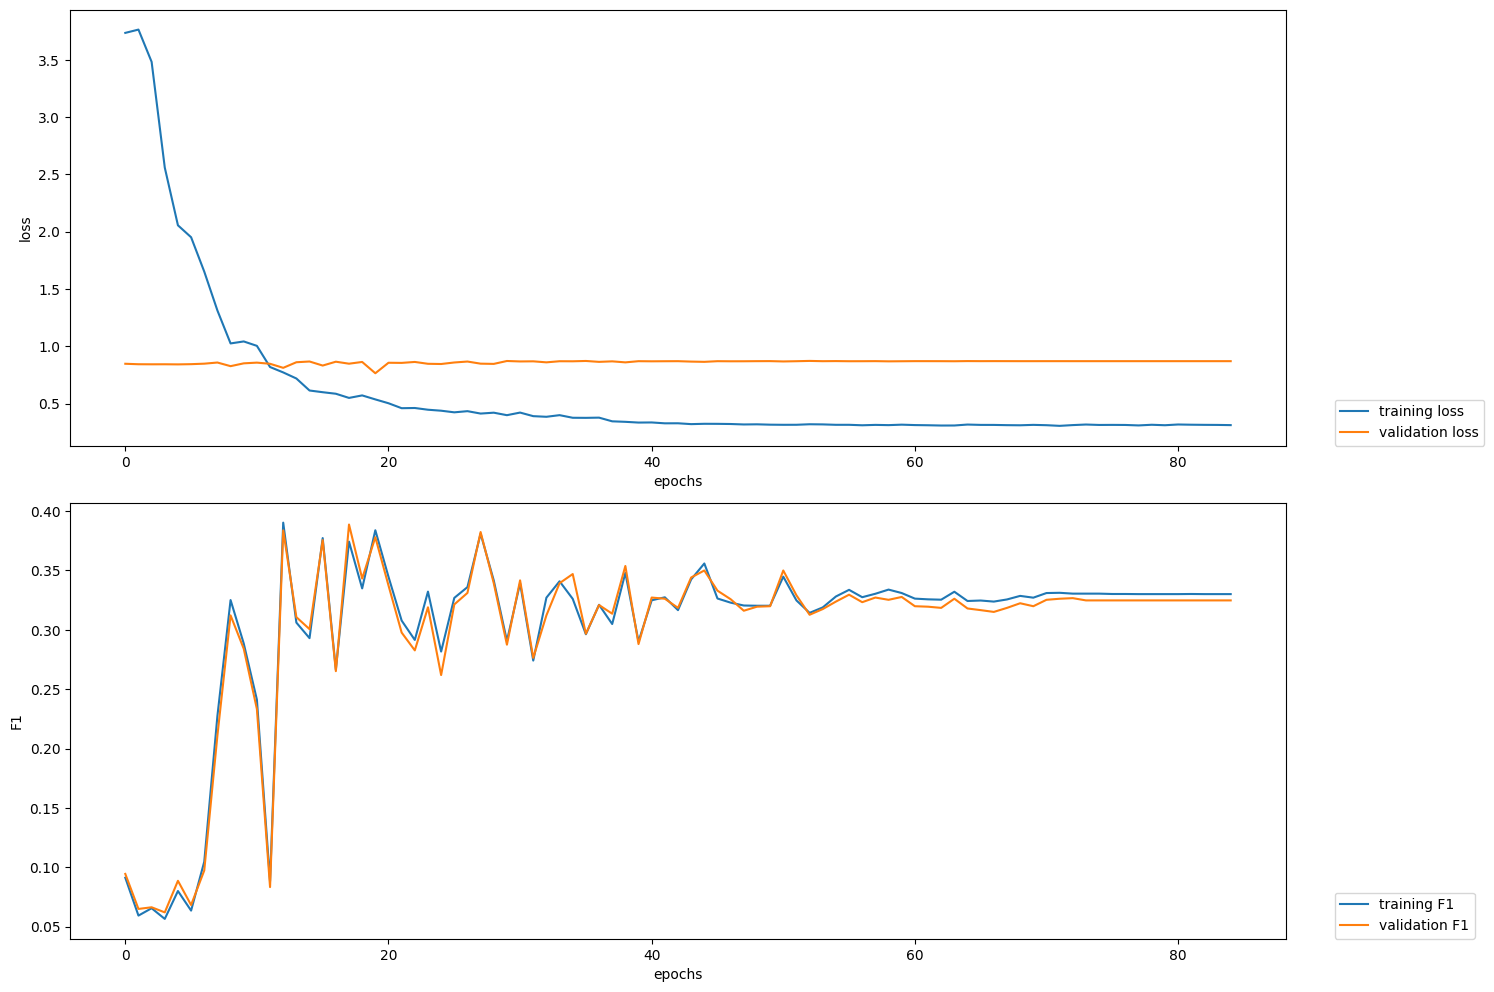

100%|██████████| 79/79 [00:32<00:00,  2.45it/s]

2023-04-21 02:48:54,085 Evaluating as a multi-label problem: True



100%|██████████| 10/10 [00:02<00:00,  3.83it/s]

2023-04-21 02:48:59,516 Evaluating as a multi-label problem: False



100%|██████████| 10/10 [00:04<00:00,  2.24it/s]

2023-04-21 02:49:04,081 Evaluating as a multi-label problem: True


,split,index,E-ADR,I-ADR,B-ADR,S-Drug,S-ADR,B-Finding,E-Finding,I-Finding,...,B-Drug,B-Symptom,S-Finding,I-Symptom,I-Drug,I-Disease,micro avg,macro avg,weighted avg,samples avg
0,train,precision,0.523926,0.314389,0.511125,0.953757,0.542763,0.0,0.0,0.0,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.518621,0.242298,0.453802,0.055397
1,train,recall,0.490302,0.156664,0.500746,0.769829,0.121056,0.0,0.0,0.0,...,0.009091,0.0,0.0,0.0,0.0,0.0,0.333927,0.102835,0.333927,0.055360
2,train,f1-score,0.506557,0.209121,0.505882,0.851979,0.197960,0.0,0.0,0.0,...,0.018018,0.0,0.0,0.0,0.0,0.0,0.406268,0.115369,0.367001,0.055373
3,train,support,3506.000000,4449.000000,3349.000000,1286.000000,1363.000000,200.0,200.0,149.0,...,110.000000,110.0,109.0,104.0,50.0,50.0,15722.000000,15722.000000,15722.000000,15722.000000
4,dev,precision,0.505643,0.252280,0.485327,0.919463,0.500000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.483453,0.133136,0.400421,NaN
5,dev,recall,0.498886,0.160542,0.486425,0.835366,0.062201,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.325266,0.102171,0.325266,NaN
6,dev,f1-score,0.502242,0.196217,0.485876,0.875399,0.110638,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.388889,0.108519,0.342883,NaN
7,dev,support,449.000000,517.000000,442.000000,164.000000,209.000000,39.0,34.0,20.0,...,20.000000,12.0,25.0,23.0,7.0,13.0,2066.000000,2066.000000,2066.000000,NaN
8,test,precision,0.536058,0.255521,0.536058,0.940000,0.709677,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.518797,0.148866,0.446338,0.058307
9,test,recall,0.504525,0.154286,0.533493,0.734375,0.139241,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.346908,0.103296,0.346908,0.058264


In [25]:
print(suf)

os.mkdir('flair_ner_model'+suf+'/classification_report')
plotter.plot_training_curves('flair_ner_model'+suf+'/loss.tsv')

# evaluate the tagger on the test set
result = tagger.evaluate(corpus.train, 
                         embeddings_storage_mode='gpu',
                         mini_batch_size=12,
                         main_evaluation_metric = ("weighted avg", "f1-score"),
                         gold_label_type='ner',
                         gold_label_dictionary=tag_dictionary)
open('flair_ner_model'+suf+'/classification_report/train.txt', 'w').write(str(result))
res1 = pd.DataFrame.from_dict(result.classification_report).reset_index()
res1.insert(loc=0, column='split', value='train')

result = tagger.evaluate(corpus.dev, 
                         embeddings_storage_mode='gpu',
                         mini_batch_size=12,
                         main_evaluation_metric = ("weighted avg", "f1-score"),
                         gold_label_type='ner',
                         gold_label_dictionary=tag_dictionary)
open('flair_ner_model'+suf+'/classification_report/dev.txt', 'w').write(str(result))
res2 = pd.DataFrame.from_dict(result.classification_report).reset_index()
res2.insert(loc=0, column='split', value='dev')

result = tagger.evaluate(corpus.test, 
                         embeddings_storage_mode='gpu',
                         mini_batch_size=12,
                         main_evaluation_metric = ("weighted avg", "f1-score"),
                         gold_label_type='ner',
                         gold_label_dictionary=tag_dictionary)
open('flair_ner_model'+suf+'/classification_report/test.txt', 'w').write(str(result))
res3 = pd.DataFrame.from_dict(result.classification_report).reset_index()
res3.insert(loc=0, column='split', value='test')

res = pd.concat([res1,res2,res3],ignore_index=True)
res.to_csv('flair_ner_model'+suf+'/classification_report.csv',index=False)
res

In [ ]:
# import time
# start_time = time.time()
# while time.time() - start_time < 1:
#     time.sleep(1)
# print('Session has timed out (2 minutes). Disconnecting...')
# !kill -9 -1

Layering can be a good idea if the NER tags in the first layer have their own set of dependent values in the second layer. This can help capture more information about the entities being recognized and provide more context for downstream tasks. However, it also increases the complexity of the annotation and the training process, so it should be used judiciously. In general, it's a good idea to start with a simple tag scheme and gradually increase complexity as needed.

    does it really matter if u use the E header

It depends on the specific task and the requirements of the downstream model. In some cases, using the E tag can help disambiguate between overlapping entities, while in other cases it may not be necessary or even desired. Ultimately, it's up to the developer to determine the appropriate tagging scheme for their specific use case.

    would adding POS as an extra NER layer help model performance or not

Adding POS as an extra NER layer may or may not help model performance, depending on the specific use case and data being analyzed.

On one hand, incorporating POS tags could provide additional context to the model and help it better distinguish between named entities and other parts of speech. For example, knowing that a word is a noun or verb could help the model determine if it is likely to be a named entity or not.

On the other hand, adding an additional layer could also increase model complexity and training time without necessarily improving performance. It may also require additional manual annotation efforts to create a labeled dataset with both NER and POS tags.

Ultimately, whether to include POS as an additional layer will depend on the specific requirements and goals of the project, as well as the available data and resources.

    besides bioes ordering (which is up-to-down), it doesn't matter what order the tags in the same domain appear in left-to-right?

Yes, that is correct. As long as the BIOES order is maintained vertically, the order of tags in the same domain from left-to-right should not impact training in flai

    different typenames must be treated as separate tasks?

Yes, that's correct. Different typenames should be treated as separate tasks because they represent different types of annotations that you want to predict. For example, in a biomedical NER task, you might want to predict the entity types of both drugs and diseases, which would be represented by two different typenames in your annotation data. Predicting both types of entities would require different models and possibly different evaluation metrics.